In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from scipy.stats import t
from soundsig.sound import BioSound
from soundsig.sound import spec_colormap



In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'

birds = [
    os.path.basename(bird)
    for bird in sorted(glob.glob(os.path.join(rootPath+dataPath, "*")), key=os.path.getmtime, reverse=True)
    if (os.path.isdir(bird))]

# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [3]:
# Load the data base
outPath = rootPath+dataPath+'HerminaDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

In [4]:
dfDataBase

bird                   site                     unit  \
0       ZF7F  ZF7F_5t_190720_152938  goodPlayback-e16-c1.pkl   
1       ZF7F  ZF7F_5t_190720_152938  goodPlayback-e16-c1.pkl   
2       ZF7F  ZF7F_5t_190720_152938  goodPlayback-e16-c1.pkl   
3       ZF7F  ZF7F_5t_190720_152938  goodPlayback-e16-c1.pkl   
4       ZF7F  ZF7F_5t_190720_152938  goodPlayback-e16-c1.pkl   
...      ...                    ...                      ...   
126662  ZF4F  ZF4F_5t_190616_102456  goodPlayback-e20-c1.pkl   
126663  ZF4F  ZF4F_5t_190616_102456  goodPlayback-e20-c1.pkl   
126664  ZF4F  ZF4F_5t_190616_102456  goodPlayback-e20-c1.pkl   
126665  ZF4F  ZF4F_5t_190616_102456  goodPlayback-e20-c1.pkl   
126666  ZF4F  ZF4F_5t_190616_102456  goodPlayback-e20-c1.pkl   

                                     stim call trial    R         z  \
0           BlaBla0506_MAF_Ag_0_fs25k.wav   Ag     0  1.0  0.670113   
1           BlaBla0506_MAF_Ag_0_fs25k.wav   Ag     1 -1.0 -0.670113   
2           BlaBla0506_MAF_Ag_0_fs25k.wav   Ag     2  1.0  0.670113   
3           BlaBla0506_MAF_Ag_0_fs25k.wav   Ag     3  0.0  0.000000   
4           BlaBla0506_MAF_Ag_1_fs25k.wav   Ag     0  0.0  0.000000   
...                                   ...  ...   ...  ...       ...   
126662  WhiWhi1415_FAF_Te_5-3-1_fs25k.wav   Te     0  1.0  0.238918   
126663  WhiWhi1415_FAF_Th_3-2-5_fs25k.wav   Th     0  3.0  0.716754   
126664  WhiWhi1415_FAF_Th_3-2-5_fs25k.wav   Th     1 -1.0 -0.238918   
126665  WhiWhi1415_FAF_Th_4-1-9_fs25k.wav   Th     0  0.0  0.000000   
126666  WhiWhi1415_FAF_Wh_2-3-1_fs25k.wav   Wh     0  0.0  0.000000   

                                                       PC  
0       [-371.0872844018543, 67.70692230077798, 37.709...  
1       [-390.8290974752949, -8.252893698728801, -4.97...  
2       [-381.22954095551694, -11.739478782846223, 33....  
3       [-413.3700305165536, 19.789477797457508, 14.91...  
4       [-413.3700305165536, 19.789477797457508, 14.91...  
...                                                   ...  
126662  [-378.17102168090486, 12.554790689628675, 65.4...  
126663  [-255.3820547782913, -75.19637820136938, 160.6...  
126664  [-279.4208127914937, -75.99459230690728, -75.2...  
126665  [-342.855105432616, 69.0482290556694, -54.1635...  
126666  [-148.59446347990402, 74.82413668911316, -175....  

[126667 rows x 9 columns]

In [5]:
# Number of Units
unitNames = np.unique(dfDataBase['site']+'_'+ dfDataBase['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBase['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBase['stim'][dfDataBase['site']+'_'+ dfDataBase['unit'] == unit]))
    # Select only Units with 110 stimuli (for now)
    if (nstimsUnit[unit] == 110):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)



191


In [6]:
# Read the results of Part 1 of DecodingCallType Runs that includes the 100 neurons chosen for the analysis.

# Read the PC and Confusion matrices data base
inPath = rootPath+dataPath+'HerminaDataBase1GoodUnitPC.pkl'
fileIn = open(inPath,"rb")
unitNamesGood = pk.load(fileIn)
confMatTot = pk.load(fileIn)
pccGood = pk.load(fileIn)
selH = pk.load(fileIn)
fileIn.close()


In [7]:
indSort = np.flip(np.argsort(pccGood))

# Printing the name of the most discriminating units
for ind in indSort:
    print(unitNamesGood[ind], pccGood[ind])

['ZF5M_9_5t_190701_125653_goodPlayback-e10-c115.pkl'] 25.723443992662204
['ZF7F_7t_190806_115742_goodPlayback-e13-c0.pkl'] 19.913887413363454
['ZF5M_8t_190627_132428_goodPlayback-e12-c76.pkl'] 19.469587931789118
['ZF4F_2t_190613_101015.old_goodPlayback-e11-c62.pkl'] 18.969013028003097
['ZF4F_3t_190613_150928_goodPlayback-e17-c97.pkl'] 18.407321658085664
['ZF4F_2t_190612_134337_goodPlayback-e17-c55.pkl'] 17.527376552936182
['ZF7F_7t_190806_115742_goodPlayback-e10-c65.pkl'] 17.24209383648092
['ZF4F_2t_190612_101201_goodPlayback-e16-c66.pkl'] 17.228639685348195
['ZF4F_2t_190612_134337_goodPlayback-e16-c98.pkl'] 16.79742152186522
['ZF7F_6t_190724_104215_goodPlayback-e19-c54.pkl'] 16.614612365305483
['ZF4F_2t_190612_101201_goodPlayback-e20-c54.pkl'] 16.490082611741798
['ZF7F_6t_190724_104215_goodPlayback-e19-c53.pkl'] 15.703764697893888
['ZF4F_3t_190613_150928_goodPlayback-e20-c99.pkl'] 15.632020061625362
['ZF4F_2t_190613_101015.old_goodPlayback-e16-c63.pkl'] 15.60808045065237
['ZF4F_2t_190

In [9]:
# THis is to load the neurons that did well as a group of 20  

inPath = rootPath+ dataPath + 'HerminaDataBase20GoodUnitPCV2.pkl'
fileIn = open(inPath,"rb")
argList = pk.load(fileIn)
confMat = pk.load(fileIn)
pcc = pk.load(fileIn)
fileIn.close()


In [37]:
numUnits = len(np.unique(np.array(argList).flatten()))

In [38]:
numUnits

100

In [10]:
# Take the one group with the highest pcc
indListMax = np.argwhere(pcc == pcc.max())[0][0]
print(argList[indListMax])
print(pcc.max())

['ZF4F_2t_190613_101015.old_goodPlayback-e11-c65.pkl'
 'ZF7F_5t_190720_152938_goodPlayback-e18-c12.pkl'
 'ZF5M_8t_190627_132428_goodPlayback-e12-c76.pkl'
 'ZF7F_8_5t_190809_133540_goodPlayback-e17-c29.pkl'
 'ZF5M_12t_190707_102304_goodPlayback-e19-c55.pkl'
 'ZF5M_11t_190704_100420_goodPlayback-e20-c66.pkl'
 'ZF4F_6t_190616_142033_goodPlayback-e19-c38.pkl'
 'ZF4F_2t_190613_101015.old_goodPlayback-e16-c63.pkl'
 'ZF4F_2t_190612_134337_goodPlayback-e8-c59.pkl'
 'ZF7F_3t_190716_130715_goodPlayback-e19-c11.pkl'
 'ZF5M_9_5t_190701_125653_goodPlayback-e10-c115.pkl'
 'ZF6M_9_5t_190805_102553_goodPlayback-e19-c71.pkl'
 'ZF4F_2t_190612_134337_goodPlayback-e20-c50.pkl'
 'ZF7F_6t_190724_104215_goodPlayback-e19-c54.pkl'
 'ZF5M_10_5t_190703_133641_goodPlayback-e15-c29.pkl'
 'ZF5M_11t_190704_100420_goodPlayback-e13-c13.pkl'
 'ZF4F_2t_190612_101201_goodPlayback-e11-c31.pkl'
 'ZF4F_2t_190612_134337_goodPlayback-e11-c27.pkl'
 'ZF4F_2t_190612_134337_goodPlayback-e19-c2.pkl'
 'ZF6M_7_5t_190723_100723_goodP

In [11]:
# Take the one group with one of the lowest pcc
indListMin = np.argwhere((pcc <31) & (pcc > 30))[0][0]
print(argList[indListMin])
print(pcc[indListMin])

['ZF6M_8t_190725_105432_goodPlayback-e15-c70.pkl'
 'ZF4F_5t_190615_114154_goodPlayback-e19-c104.pkl'
 'ZF4F_2t_190612_101201_goodPlayback-e16-c66.pkl'
 'ZF4F_2t_190612_134337_goodPlayback-e8-c59.pkl'
 'ZF6M_8t_190725_105432_goodPlayback-e15-c71.pkl'
 'ZF7F_7t_190806_115742_goodPlayback-e19-c32.pkl'
 'ZF6M_8t_190725_105432_goodPlayback-e15-c67.pkl'
 'ZF5M_8t_190627_132428_goodPlayback-e12-c76.pkl'
 'ZF6M_10_5t_190808_102150_goodPlayback-e21-c72.pkl'
 'ZF6M_7_5t_190723_141539_goodPlayback-e11-c7.pkl'
 'ZF4F_6t_190616_142033_goodPlayback-e16-c70.pkl'
 'ZF5M_11t_190704_100420_goodPlayback-e13-c13.pkl'
 'ZF7F_5_5t_190722_121506_goodPlayback-e11-c1.pkl'
 'ZF7F_6t_190724_104215_goodPlayback-e19-c54.pkl'
 'ZF7F_5t_190720_152938_goodPlayback-e19-c65.pkl'
 'ZF5M_10t_190702_095313_goodPlayback-e11-c57.pkl'
 'ZF4F_2t_190613_101015.old_goodPlayback-e19-c60.pkl'
 'ZF7F_3t_190716_130715_goodPlayback-e19-c11.pkl'
 'ZF4F_5t_190615_114154_goodPlayback-e20-c56.pkl'
 'ZF5M_8t_190627_132428_goodPlayback-e1

In [18]:
def spikeTriggeredMPS(unit, plotFlg = 0, code='z'):
    # Calculates the weighed average MPS based on the neural response
    # if plotFlg = 1 you get the output plots
    # if plotFlg = 2 you get the output plots and all intermediate mps
   
    # Number of PCs (for PC code)
    nPCs = dfDataBase['PC'][0].shape[0]
    
    # Find the unique stims played for the chosen unit
    unitIndex = dfDataBase.index[dfDataBase['site']+'_'+ dfDataBase['unit'] == unit]
    unitIndexLen = len(unitIndex)
    stimList = list(dfDataBase['stim'][unitIndex].array)
    
    stimNames = np.unique(stimList)
    
    # Calculate all the MPS, store them and make a running total for averaging
    firstTime = True
    stimMPS = []   
    for stim in stimNames:

        # These are the rows that have this stim. 
        unitIndexStim = [ind for ind in unitIndex if dfDataBase['stim'][ind] == stim]
        
        # Use the data in the first unit to find the stim           
        playbackPkl = dfDataBase['unit'][unitIndexStim[0]]
        playPklPath = rootPath + dataPath + dfDataBase['bird'][unitIndexStim[0]] + '/sites/' + dfDataBase['site'][unitIndexStim[0]] + '/PlaybackPkl/'
        pklFile = playPklPath + playbackPkl
        fileIn = open(pklFile, 'rb')
        unitInfo = pk.load(fileIn)
        dfAbsTime = pk.load(fileIn)
        dfRelTime = pk.load(fileIn)
        fileIn.close()
                
        for index, row in dfRelTime.iterrows():
            if row['file'] == stim:
                break
        
        indStart = np.nonzero(row['tStim']>= -0.5)[0][0]
        indEnd = np.nonzero(row['tStim']>= 0.5)[0][0]
        
        wavSound = row['stimWav'][indStart:indEnd]
        fs = np.fix(1.0/(row['tStim'][1]-row['tStim'][0]))
        
        # Create BioSound Object and calculate basic sound features
        myBioSound = BioSound(soundWave=wavSound, fs=fs, emitter=stim.split('_')[0], calltype = row['call_type'])
        myBioSound.spectroCalc(spec_sample_rate=1000, freq_spacing = 50, min_freq=0, max_freq=10000)
        myBioSound.rms = myBioSound.sound.std() 
        myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 1000)
        myBioSound.spectrum(f_high=10000)
        myBioSound.mpsCalc(window=0.1, Norm = True)
        
        # Store in list
        stimMPS.append(myBioSound.mps)
        
        # Plot if asked
        if plotFlg > 1:
            myBioSound.plot(DBNOISE=50, f_low=250, f_high=10000)
        
        # Running sum for calculating average
        if firstTime:
            mpsAVG = np.copy(myBioSound.mps)
            firstTime = False
        else:
            mpsAVG += myBioSound.mps

        
    # Find the average mps
    mpsAVG /= len(stimNames)
    
    
    # Repeat the stimulus loop to calculate the triggered mps
    # THe PC code assumes 5 PCs
    if code == 'z':
        mpsTRG = np.zeros(mpsAVG.shape)
    elif code == 'PC':
        mpsTRG = [np.zeros(mpsAVG.shape), np.zeros(mpsAVG.shape), np.zeros(mpsAVG.shape), np.zeros(mpsAVG.shape), np.zeros(mpsAVG.shape), np.zeros(mpsAVG.shape)]
    for istim, stim in enumerate(stimNames):

        # These are the rows that have this stim. 
        unitIndexStim = [ind for ind in unitIndex if dfDataBase['stim'][ind] == stim]
        
        # The neural weight
        neuralWeight = 0
        for ind in unitIndexStim:
            neuralWeight += dfDataBase['z'][ind]
        neuralWeight /= len(unitIndexStim)
        
        # The mps deviation
        if code == 'z':
            mpsTRG += (stimMPS[istim]-mpsAVG)*neuralWeight
        elif code == 'PC':
            mpsTRG[0] += (stimMPS[istim]-mpsAVG)*neuralWeight
            neuralWeight = np.zeros((5,))
            for ind in unitIndexStim:
                neuralWeight += dfDataBase['PC'][ind]
            neuralWeight /= len(unitIndexStim)
            for ipc in range(5):
                mpsTRG[ipc+1] += (stimMPS[istim]-mpsAVG)*neuralWeight[ipc]
                
        
    if plotFlg > 0:
        DBNOISE = 50
        plt.figure(dpi=300)
        plt.subplot(1,2,1)
        cmap = plt.get_cmap('jet')
        ex = (myBioSound.wt.min(), myBioSound.wt.max(), myBioSound.wf.min()*1e3, myBioSound.wf.max()*1e3)
        logMPS = 10.0*np.log10(mpsAVG)
        maxMPS = logMPS.max()
        minMPS = maxMPS-DBNOISE
        logMPS[logMPS < minMPS] = minMPS
        plt.imshow(logMPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
        plt.ylabel('Spectral Frequency (Cycles/KHz)')
        plt.xlabel('Temporal Frequency (Hz)')
        plt.colorbar()
        plt.ylim((0,6))
        plt.xlim((-100, 100))
        plt.title('Average MPS')
        plt.subplot(1,2,2)
        if code == 'z':
            plt.imshow(mpsTRG, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
        elif code == 'PC':
            plt.imshow(mpsTRG[0], interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
        plt.ylabel('Spectral Frequency (Cycles/KHz)')
        plt.xlabel('Temporal Frequency (Hz)')
        plt.colorbar()
        plt.ylim((0,6))
        plt.xlim((-100, 100))
        plt.clim((-1000, 1000))
        plt.title('Triggered MPS')
        
        plt.show()
            
        

    return mpsAVG, mpsTRG, myBioSound.wt, myBioSound.wf



In [26]:
# Loop through all 100 neurons that gave the best decoding of categories
code = 'PC'

mpsAVGList = []
mpsTRGList = []

for i,unit in enumerate(unitNamesGood):
    mpsAVG, mpsTRG, wt, wf = spikeTriggeredMPS(unit[0], plotFlg = 0, code=code)
    
    mpsAVGList.append(mpsAVG)
    mpsTRGList.append(mpsTRG)
    print('Done with unit', i, unit[0])


/Users/frederictheunissen/Code/songephys/src/soundsig/soundsig/sound.py:279: RuntimeWarning: divide by zero encountered in log10
  self.spectro = 20*np.log10(np.abs(spec))


Done with unit 0 ZF4F_2t_190612_101201_goodPlayback-e11-c31.pkl
Done with unit 1 ZF4F_2t_190612_101201_goodPlayback-e16-c66.pkl
Done with unit 2 ZF4F_2t_190612_101201_goodPlayback-e17-c36.pkl
Done with unit 3 ZF4F_2t_190612_101201_goodPlayback-e17-c38.pkl
Done with unit 4 ZF4F_2t_190612_101201_goodPlayback-e19-c2.pkl
Done with unit 5 ZF4F_2t_190612_101201_goodPlayback-e20-c54.pkl
Done with unit 6 ZF4F_2t_190612_101201_goodPlayback-e20-c55.pkl
Done with unit 7 ZF4F_2t_190612_101201_goodPlayback-e8-c22.pkl
Done with unit 8 ZF4F_2t_190612_101201_goodPlayback-e8-c38.pkl
Done with unit 9 ZF4F_2t_190612_101201_goodPlayback-e9-c1.pkl
Done with unit 10 ZF4F_2t_190612_134337_goodPlayback-e11-c27.pkl
Done with unit 11 ZF4F_2t_190612_134337_goodPlayback-e11-c35.pkl
Done with unit 12 ZF4F_2t_190612_134337_goodPlayback-e16-c94.pkl
Done with unit 13 ZF4F_2t_190612_134337_goodPlayback-e16-c96.pkl
Done with unit 14 ZF4F_2t_190612_134337_goodPlayback-e16-c98.pkl
Done with unit 15 ZF4F_2t_190612_134337_

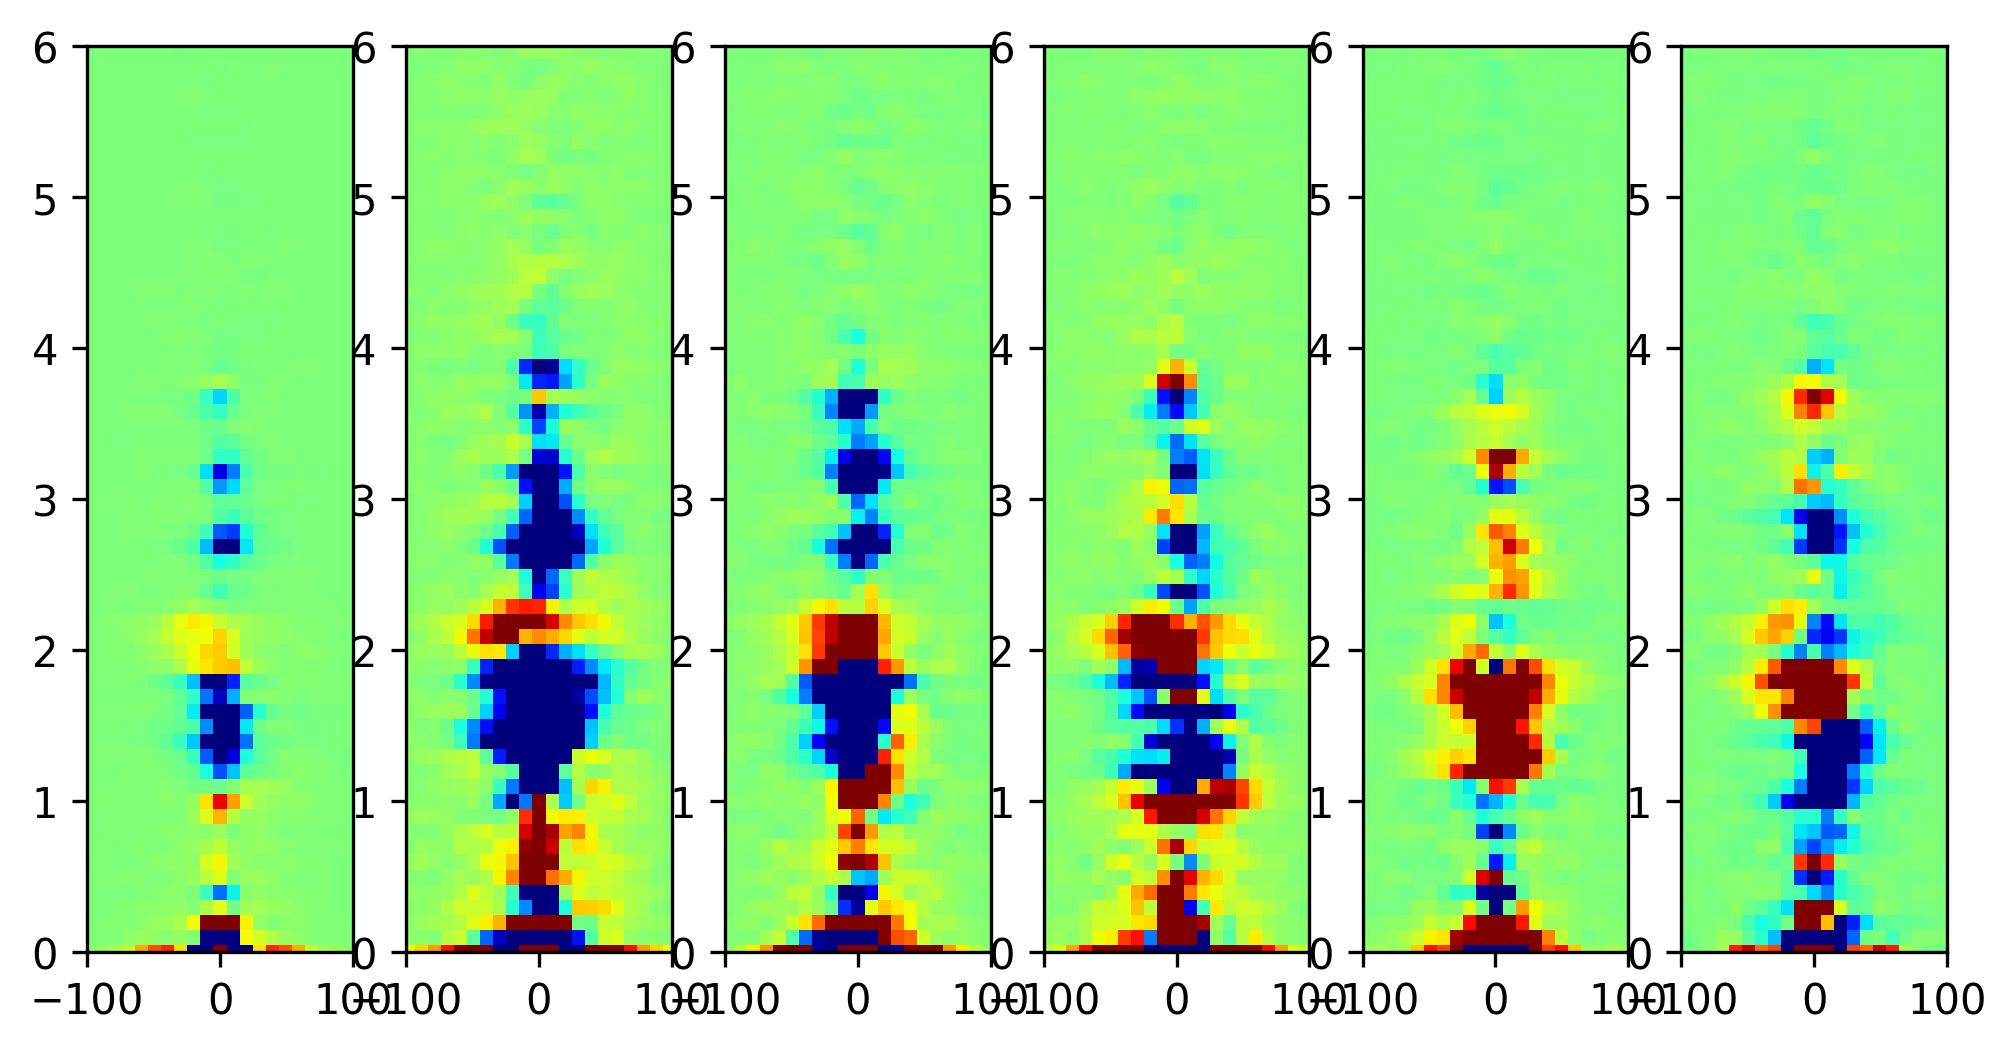

In [27]:
# Plot the first one to check
if code == 'PC':
    plt.figure(dpi=300, figsize=(8,4))
    cmap = plt.get_cmap('jet')
    ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)

    for iplot,unit in enumerate(unitNamesGood):
        plt.subplot(1,6,1)
        plt.imshow(mpsTRGList[iplot][0], interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
        plt.ylim((0,6))
        plt.xlim((-100, 100))
        plt.clim((-1000, 1000))
        for ipc in range(5):
            plt.subplot(1,6,ipc+2)
            plt.imshow(mpsTRGList[iplot][ipc+1], interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    #plt.ylabel('Spectral Frequency (Cycles/KHz)')
    #plt.xlabel('Temporal Frequency (Hz)')
            plt.ylim((0,6))
            plt.xlim((-100, 100))
            plt.clim((-20000, 20000))
    #plt.title(argList[indListMax][iplot])
        plt.show()
        if iplot == 0:
            break
    


In [28]:
# save the Modulation Transfer Functions

outPath = rootPath+ dataPath + 'HerminaGoodUnitsMPS_PC.pkl'

fileOut = open(outPath,"wb")
pk.dump(unitNamesGood, fileOut)
pk.dump(mpsAVGList, fileOut)
pk.dump(mpsTRGList, fileOut)
pk.dump(wt, fileOut)
pk.dump(wf, fileOut)
fileOut.close()



In [12]:
# Read the Modulation Transfer Functions

inPath = rootPath+ dataPath + 'HerminaGoodUnitsMPS_PC.pkl'

fileIn = open(inPath,"rb")
unitNamesGood= pk.load(fileIn)
mpsAVGList = pk.load(fileIn)
mpsTRGList = pk.load(fileIn)
wt = pk.load(fileIn)
wf = pk.load(fileIn)
fileIn.close()



In [13]:
for i, unit in enumerate(unitNamesGood):
    print(unit)
    print(unit[0])
    if i == 20:
        break

['ZF4F_2t_190612_101201_goodPlayback-e11-c31.pkl']
ZF4F_2t_190612_101201_goodPlayback-e11-c31.pkl
['ZF4F_2t_190612_101201_goodPlayback-e16-c66.pkl']
ZF4F_2t_190612_101201_goodPlayback-e16-c66.pkl
['ZF4F_2t_190612_101201_goodPlayback-e17-c36.pkl']
ZF4F_2t_190612_101201_goodPlayback-e17-c36.pkl
['ZF4F_2t_190612_101201_goodPlayback-e17-c38.pkl']
ZF4F_2t_190612_101201_goodPlayback-e17-c38.pkl
['ZF4F_2t_190612_101201_goodPlayback-e19-c2.pkl']
ZF4F_2t_190612_101201_goodPlayback-e19-c2.pkl
['ZF4F_2t_190612_101201_goodPlayback-e20-c54.pkl']
ZF4F_2t_190612_101201_goodPlayback-e20-c54.pkl
['ZF4F_2t_190612_101201_goodPlayback-e20-c55.pkl']
ZF4F_2t_190612_101201_goodPlayback-e20-c55.pkl
['ZF4F_2t_190612_101201_goodPlayback-e8-c22.pkl']
ZF4F_2t_190612_101201_goodPlayback-e8-c22.pkl
['ZF4F_2t_190612_101201_goodPlayback-e8-c38.pkl']
ZF4F_2t_190612_101201_goodPlayback-e8-c38.pkl
['ZF4F_2t_190612_101201_goodPlayback-e9-c1.pkl']
ZF4F_2t_190612_101201_goodPlayback-e9-c1.pkl
['ZF4F_2t_190612_134337_goodPl

In [14]:
# Calculate relative power in each componnent.
allz = []
allPC = []
neuralNoise = np.zeros(len(unitNamesGood,))

for i,unit in enumerate(unitNamesGood):
    unitIndex = dfDataBase.index[dfDataBase['site']+'_'+ dfDataBase['unit'] == unit[0]]
    unitNoise = {'Be': [], 'LT': [], 'Th': [], 
             'Di': [], 'Ag': [], 'Wh': [], 'Ne': [ ],
             'Te': [], 'DC': [], 'So': []}
    for ind in unitIndex:
        allz.append(dfDataBase['z'][ind])
        allPC.append(dfDataBase['PC'][ind])
        unitNoise[dfDataBase['call'][ind]].append(dfDataBase['z'][ind])
    
    unitNoiseComb = 0
    for callType in unitNoise:
        mean = np.mean(unitNoise[callType])
        std = np.std(unitNoise[callType])
        #if mean == 0 :
        #    unitNoiseComb += 1
        #else:
        #    unitNoiseComb += std/np.abs(mean)
        unitNoiseComb += std**2
    neuralNoise[i] = unitNoiseComb/10.0
        
stdz = np.std(allz)
stdPC = np.std(np.array(allPC), axis = 0)



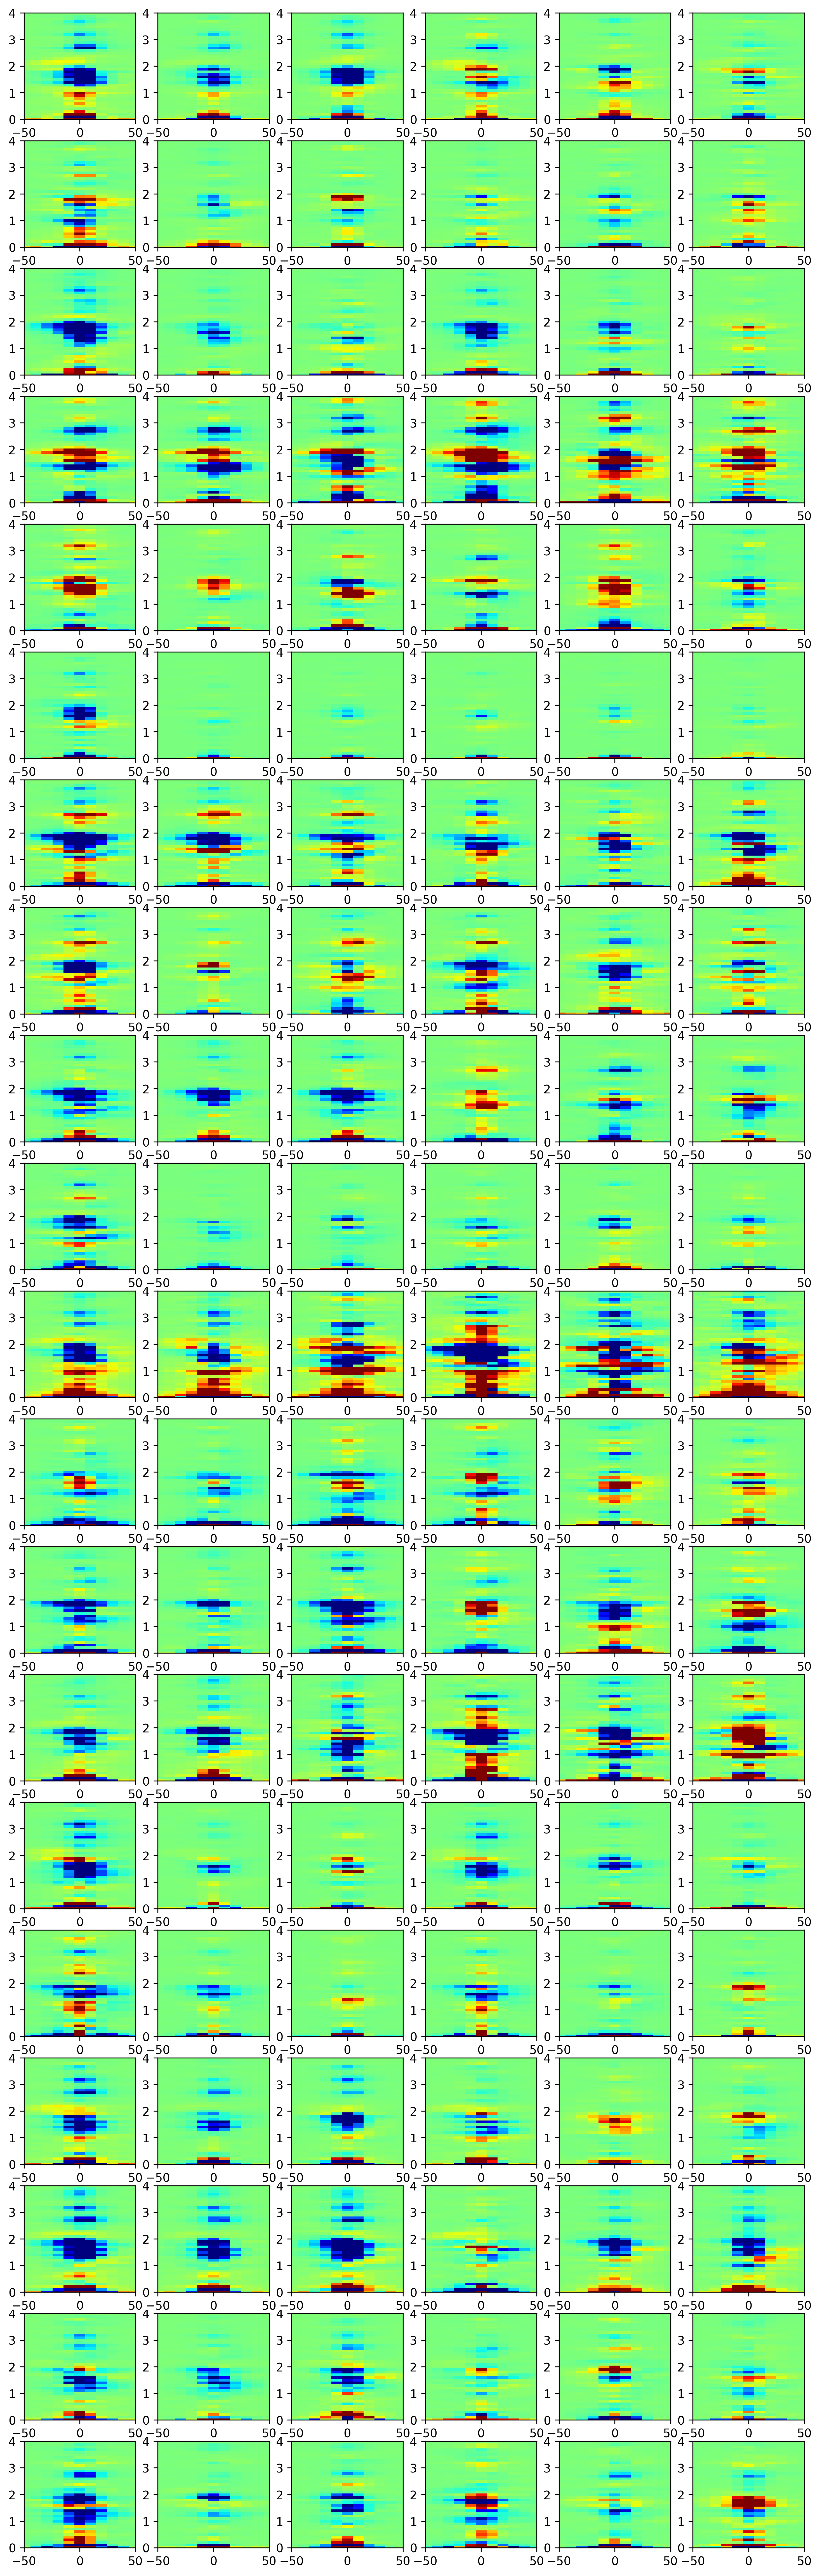

In [15]:
# Plot all Triggered MPS for Top 20

plt.figure(dpi=300, figsize=(12, 40))
cmap = plt.get_cmap('jet')
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)

for iplot,unit in enumerate(argList[indListMax]):
    indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
    
    plt.subplot(20,6,iplot*6+1)
    plt.imshow(mpsTRGList[indUnit][0], interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    #plt.ylabel('Spectral Frequency (Cycles/KHz)')
    #plt.xlabel('Temporal Frequency (Hz)')
    plt.ylim((0,4))
    plt.xlim((-50, 50))
    plt.clim((-1000*stdz, 1000*stdz))
    #plt.title(argList[indListMax][iplot])
    for ipc in range(5):
        plt.subplot(20,6, iplot*6+ipc+2)
        plt.imshow(mpsTRGList[indUnit][ipc+1], interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
        plt.ylim((0,4))
        plt.xlim((-50, 50))
        plt.clim((-1000*stdPC[ipc], 1000*stdPC[ipc]))
    
plt.savefig('/Users/frederictheunissen/Desktop/MTFPCBest20Hermina.eps')




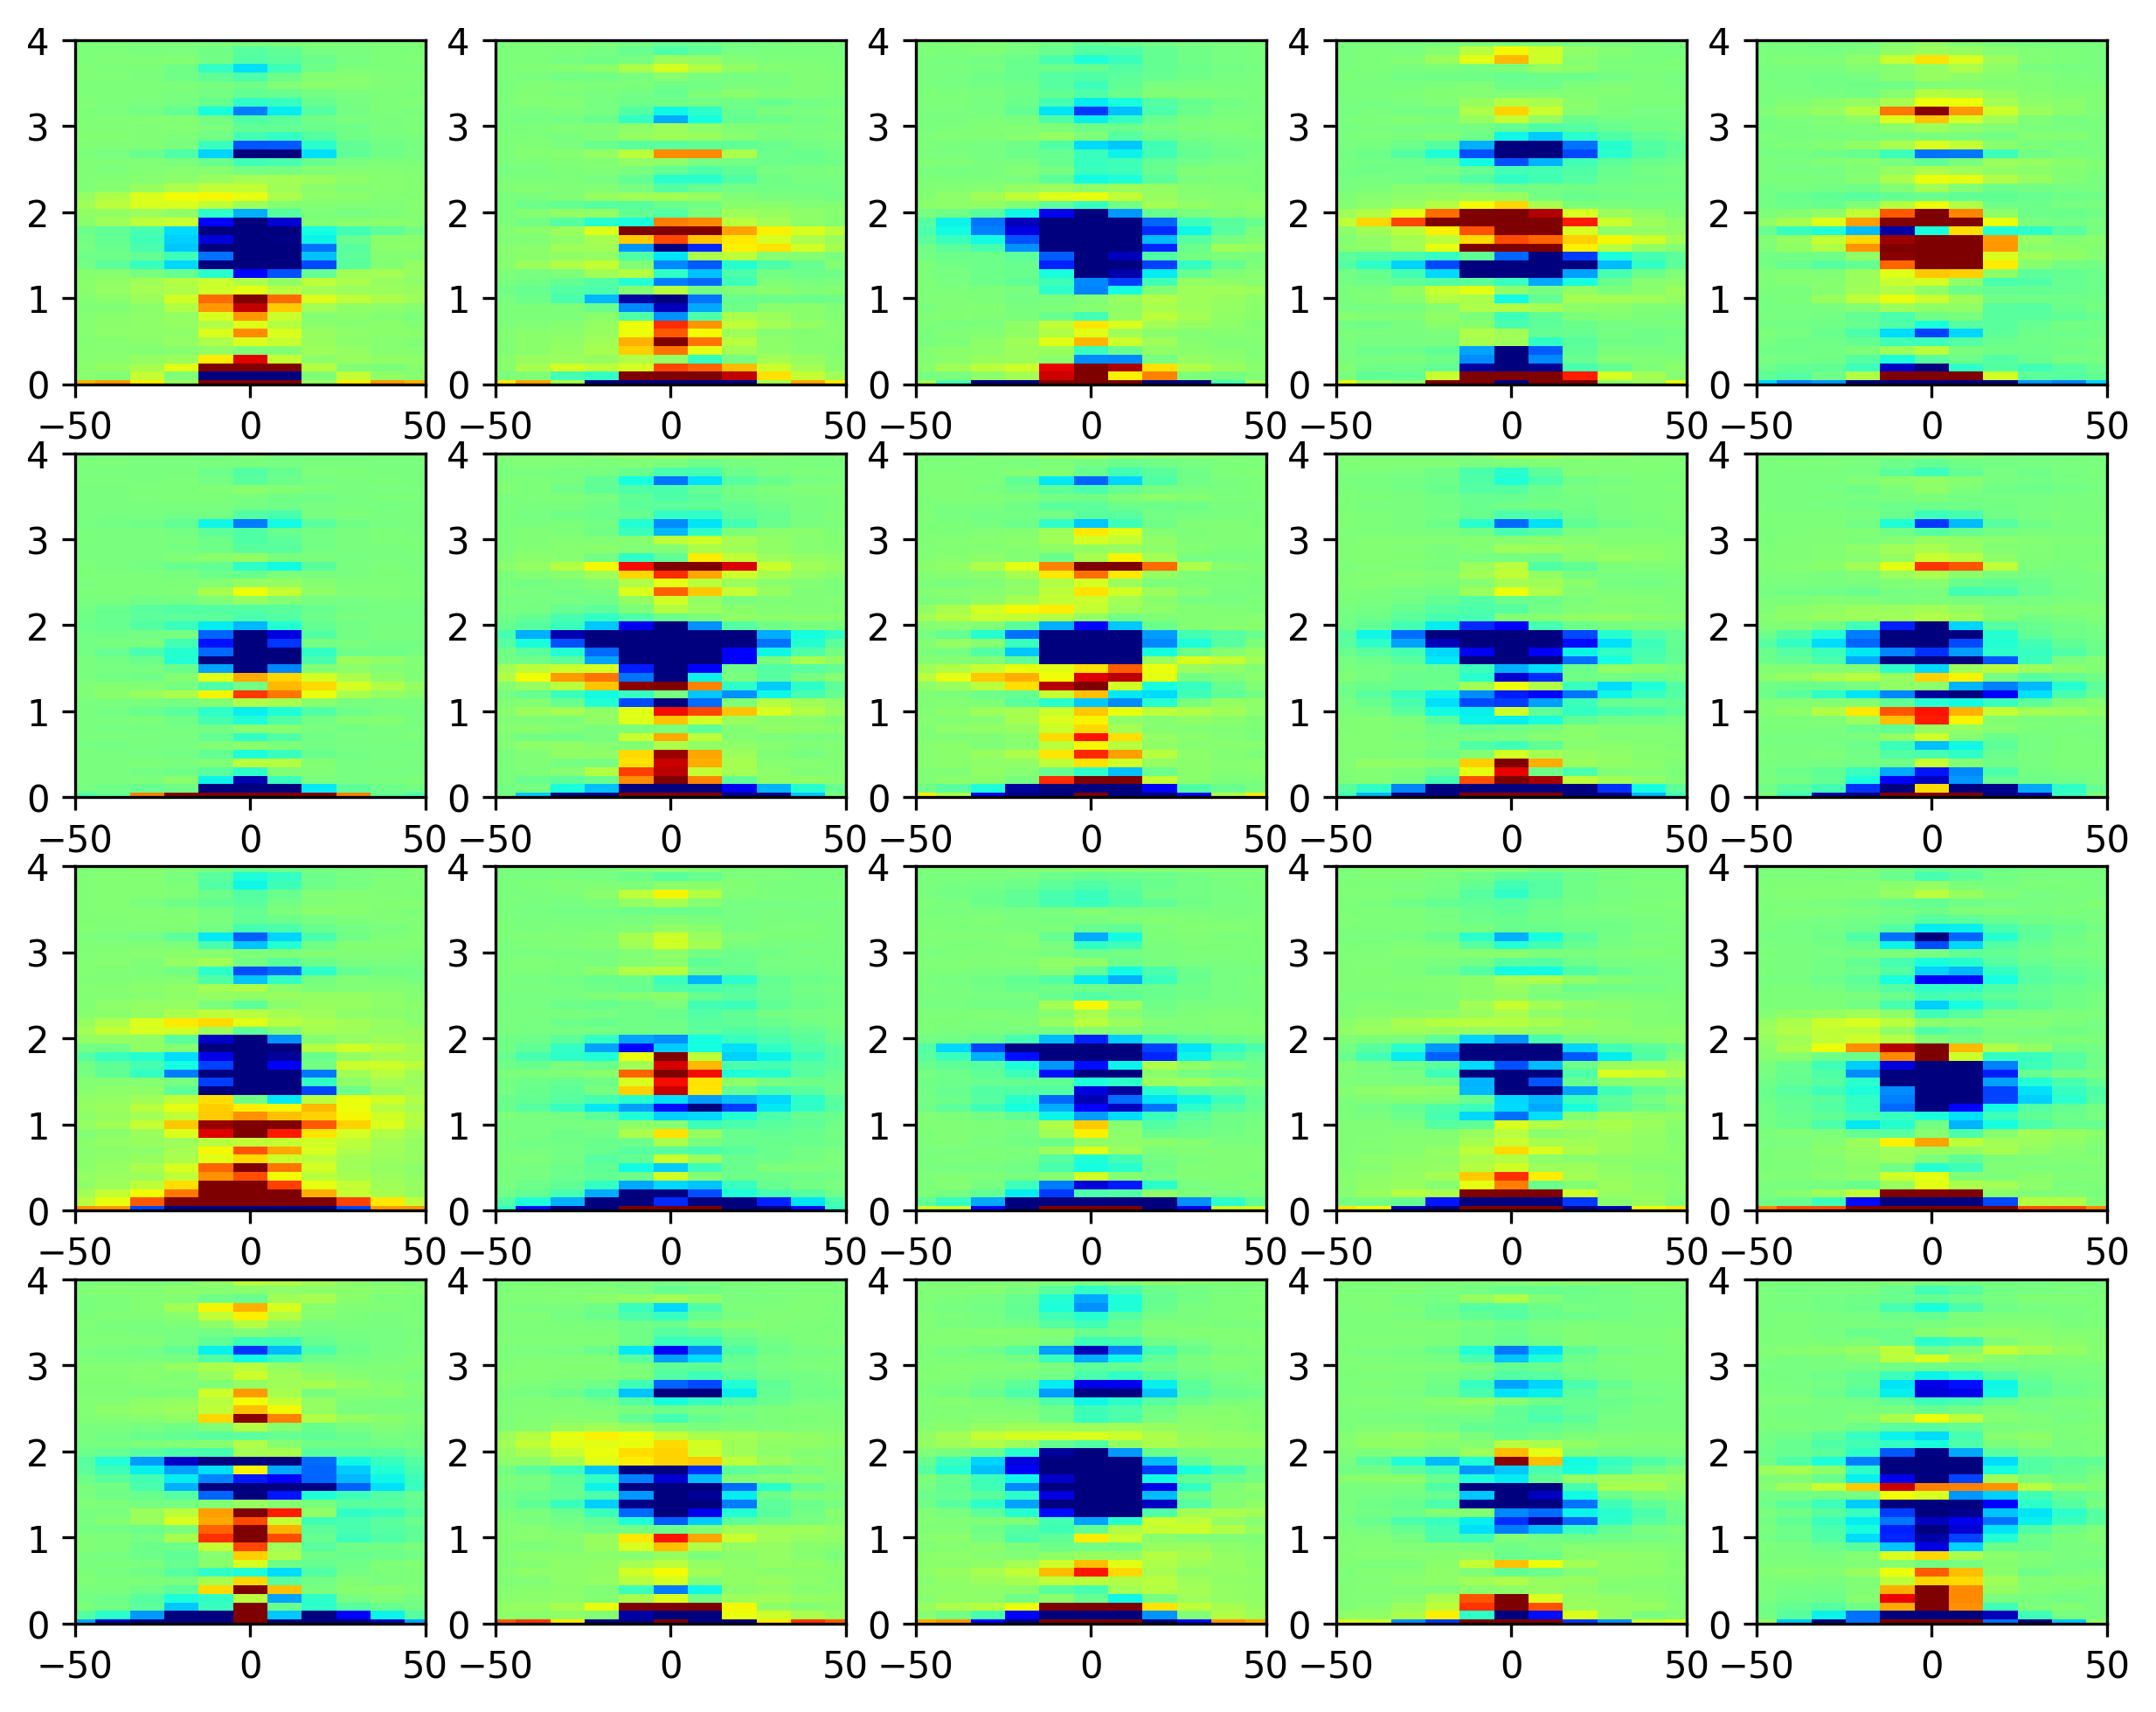

In [23]:
# Plot all Triggered MPS for Top 20

plt.figure(dpi=300, figsize=(10, 8))
cmap = plt.get_cmap('jet')
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)

for iplot,unit in enumerate(argList[indListMax]):
    indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
    
    plt.subplot(4,5,iplot+1)
    plt.imshow(mpsTRGList[indUnit][0], interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    #plt.ylabel('Spectral Frequency (Cycles/KHz)')
    #plt.xlabel('Temporal Frequency (Hz)')
    plt.ylim((0,4))
    plt.xlim((-50, 50))
    plt.clim((-1000*stdz, 1000*stdz))
    
plt.savefig('/Users/frederictheunissen/Desktop/MTFBest20Hermina.eps')

In [16]:
# Calculate Pair-wise correlation
indTLow = np.argwhere(wt>-50)[0][0]
indTHigh = np.argwhere(wt>50)[0][0]
indFLow = np.argwhere(wf>=0)[0][0]
indFHigh = np.argwhere(wf*1000>4)[0][0]


mtfCorr = 0
nCorr = 0
for unit1 in argList[indListMax]:
    indUnit1 = np.argwhere(np.array(unitNamesGood) == unit1)[0][0]
    for unit2 in argList[indListMax]:
        if unit1 == unit2:
            continue
        indUnit2 = np.argwhere(np.array(unitNamesGood) == unit2)[0][0]    
        mtfCorr +=  np.corrcoef(mpsTRGList[indUnit1][0][indFLow:indFHigh, indTLow:indTHigh].flatten(), mpsTRGList[indUnit2][0][indFLow:indFHigh, indTLow:indTHigh].flatten()) 
        nCorr += 1
    
print('Average Correlation Coefficient', mtfCorr/nCorr)

Average Correlation Coefficient [[1.         0.31272177]
 [0.31272177 1.        ]]


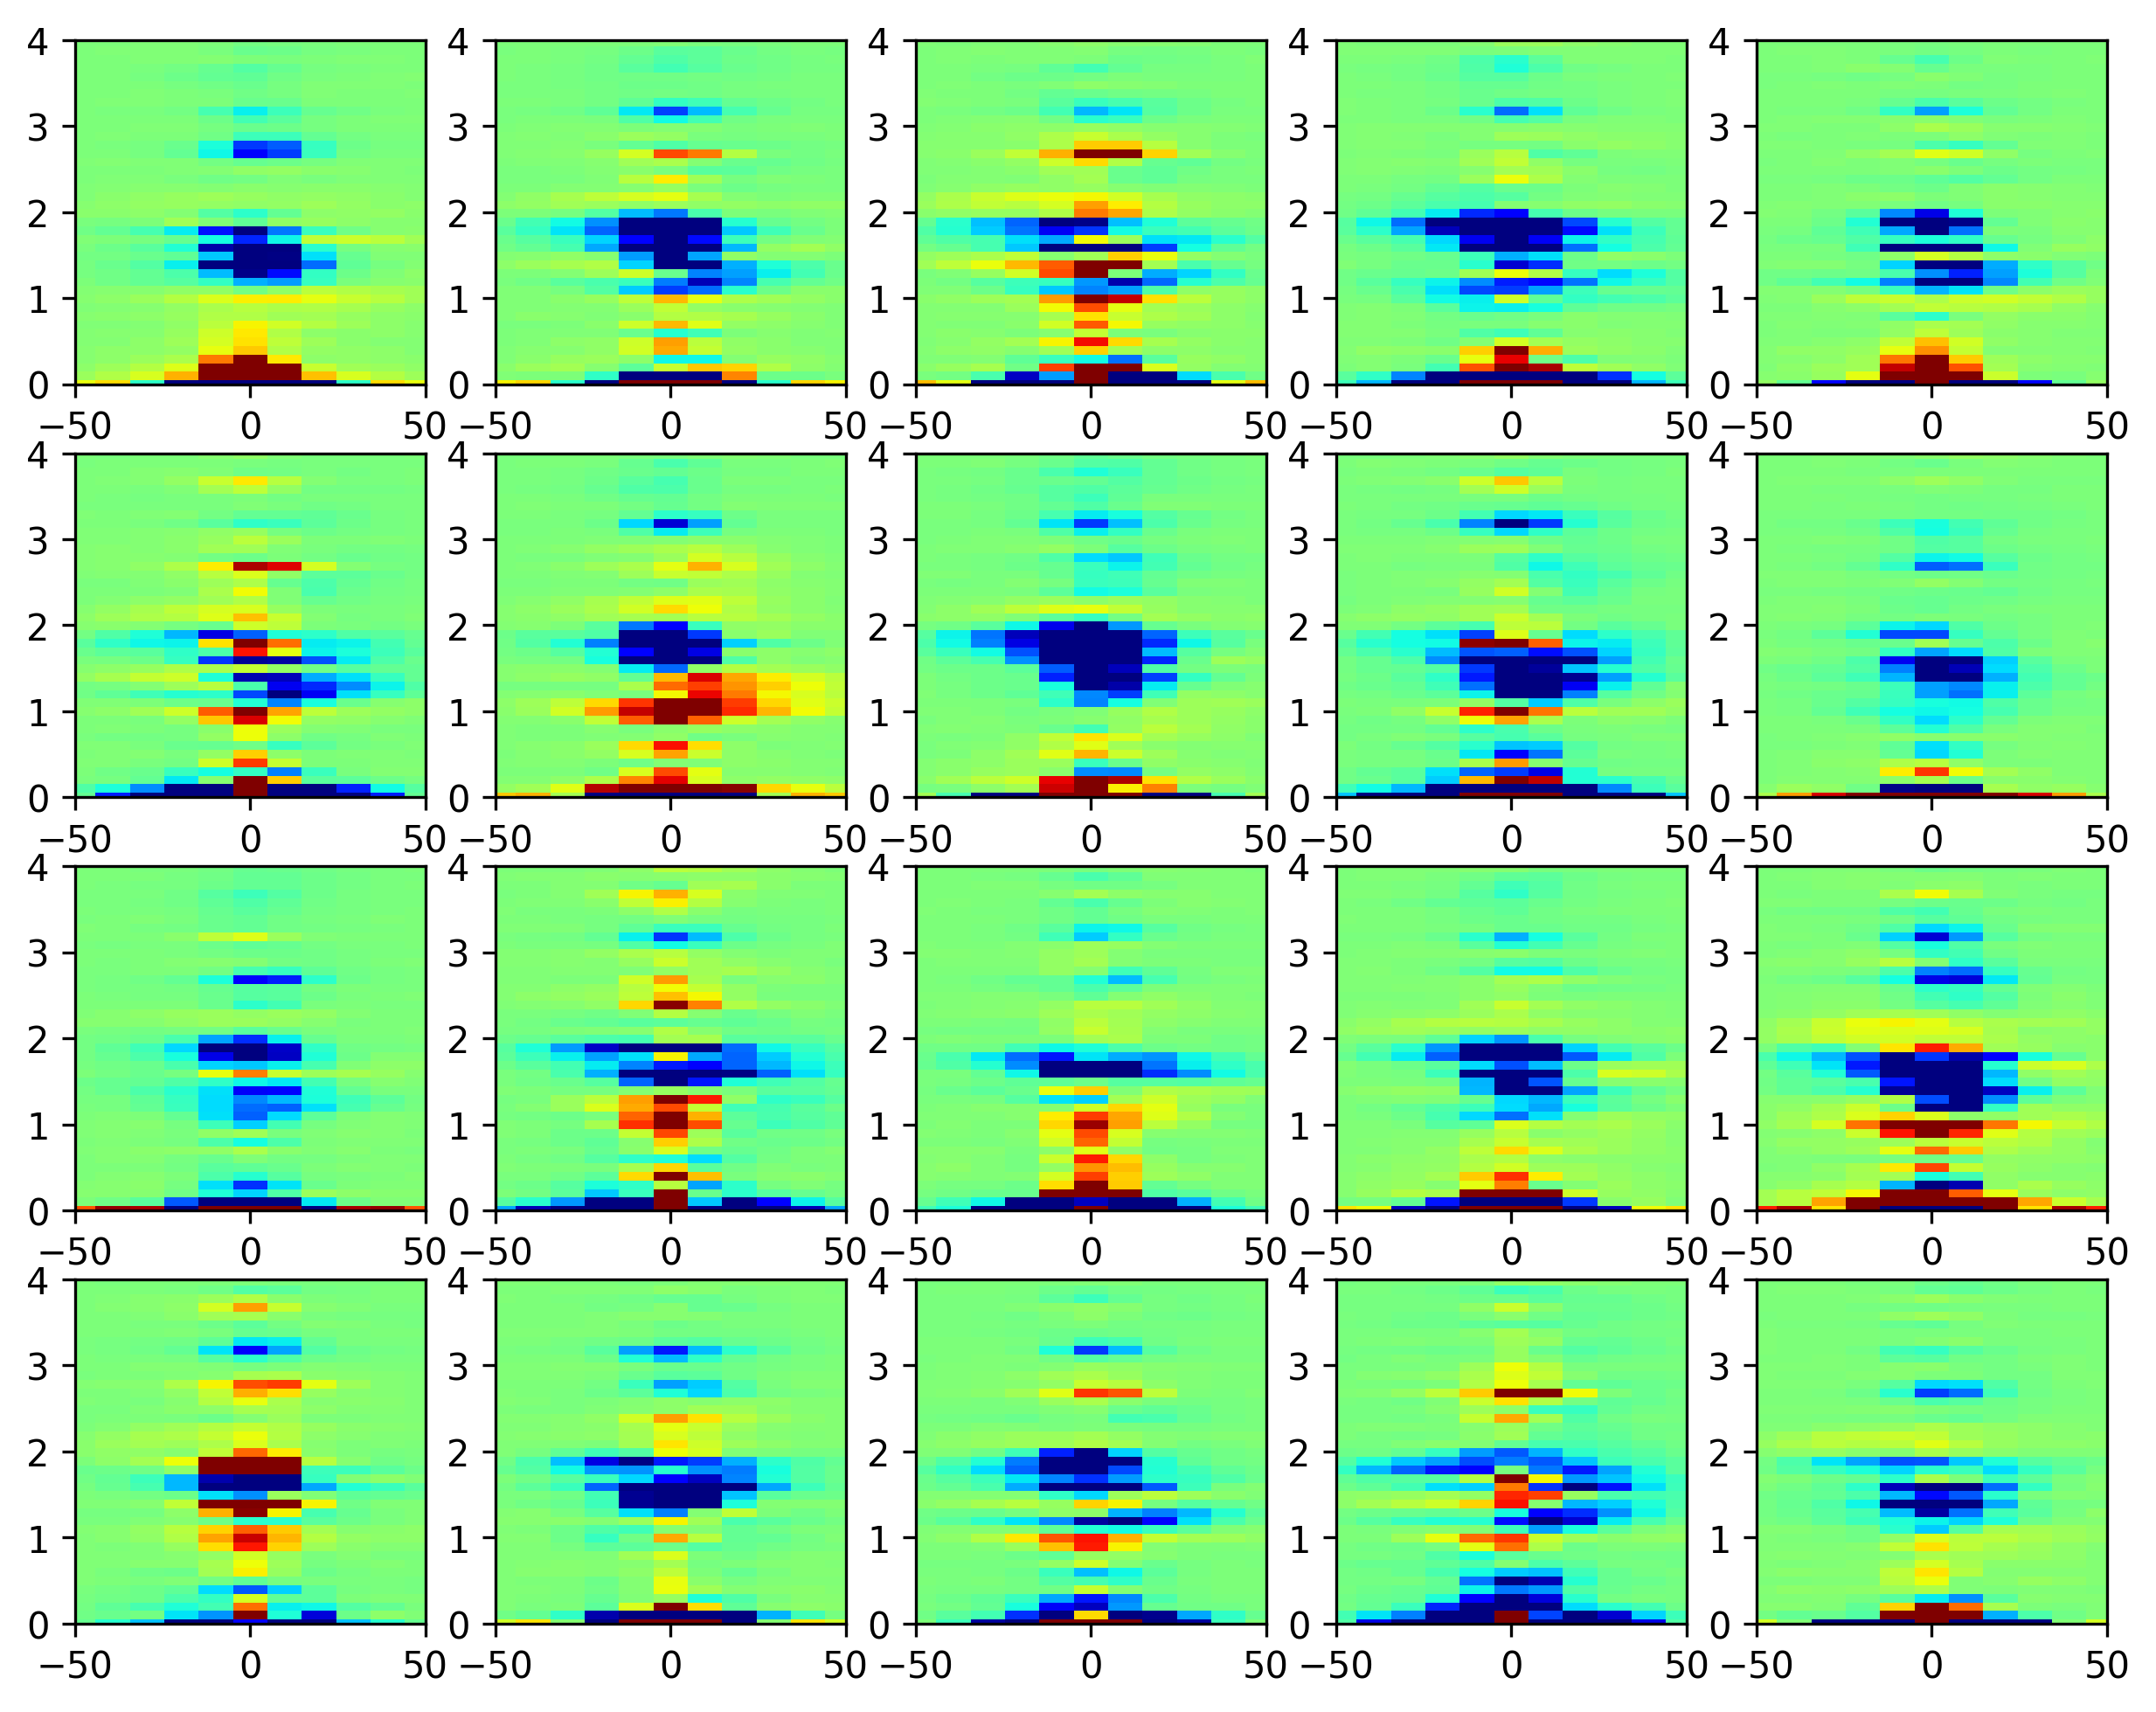

In [25]:
# Plot all Triggered MPS for Bottom 20

plt.figure(dpi=300, figsize=(10,8))
cmap = plt.get_cmap('jet')
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)

for iplot,unit in enumerate(argList[indListMin]):
    indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
    plt.subplot(4,5,iplot+1)
    plt.imshow(mpsTRGList[indUnit][0], interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    #plt.ylabel('Spectral Frequency (Cycles/KHz)')
    #plt.xlabel('Temporal Frequency (Hz)')
    plt.ylim((0,4))
    plt.xlim((-50, 50))
    plt.clim((-1000*stdz, 1000*stdz))
    #plt.title(argList[indListMax][iplot])
    
plt.savefig('/Users/frederictheunissen/Desktop/MTFWorse20Hermina.eps')



In [17]:
# Calculate Pair-wise correlation

mtfCorr = 0
nCorr = 0
for unit1 in argList[indListMin]:
    indUnit1 = np.argwhere(np.array(unitNamesGood) == unit1)[0][0]
    for unit2 in argList[indListMin]:
        if unit1 == unit2:
            continue
        indUnit2 = np.argwhere(np.array(unitNamesGood) == unit2)[0][0]    
        mtfCorr +=  np.corrcoef(mpsTRGList[indUnit1][0][indFLow:indFHigh, indTLow:indTHigh].flatten(), mpsTRGList[indUnit2][0][indFLow:indFHigh, indTLow:indTHigh].flatten()) 
        nCorr += 1
    
print('Average Correlation Coefficient', mtfCorr/nCorr)

Average Correlation Coefficient [[1.         0.42042607]
 [0.42042607 1.        ]]


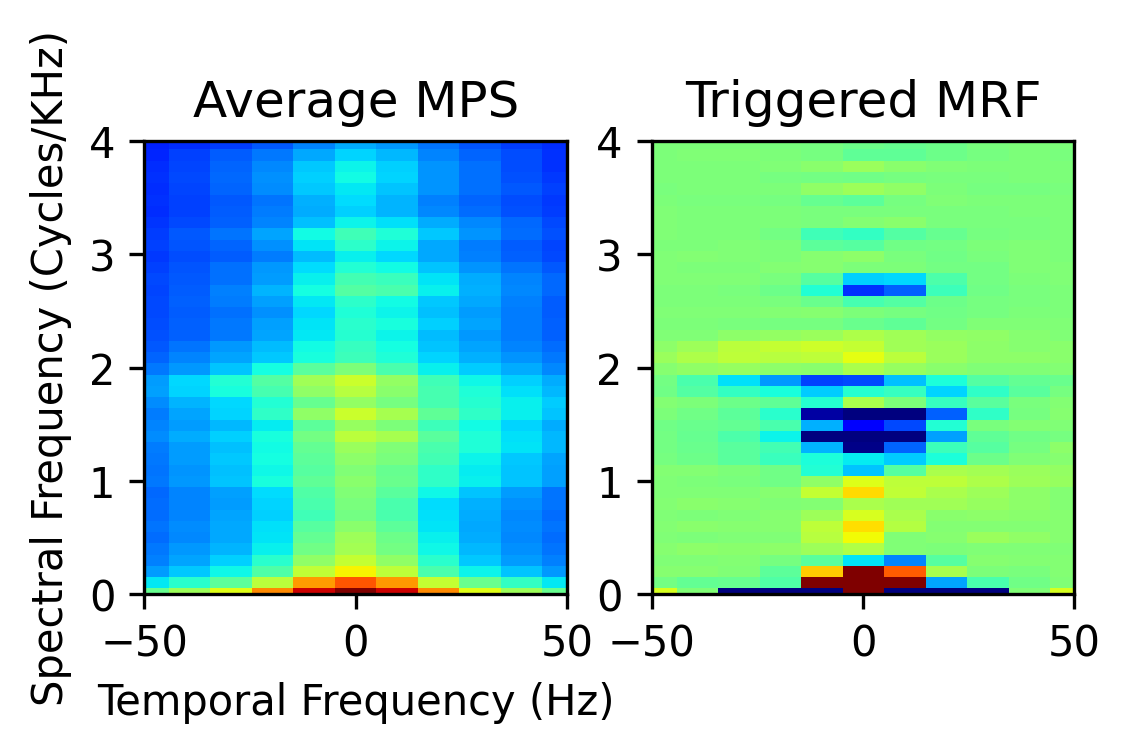

In [28]:
# Plot the last one that was run in big to zoom in

#print('-------------------------', unit, '-----------------------------')
DBNOISE = 50
plt.figure(dpi=300, figsize=(4,2))
plt.subplot(1,2,1)
cmap = plt.get_cmap('jet')
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)
logMPS = 10.0*np.log10(mpsAVGList[indUnit])
maxMPS = logMPS.max()
minMPS = maxMPS-DBNOISE
logMPS[logMPS < minMPS] = minMPS
plt.imshow(logMPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
# plt.colorbar()
plt.ylim((0,4))
plt.xlim((-50, 50))
plt.title('Average MPS')
plt.subplot(1,2,2)
plt.imshow(mpsTRGList[indUnit][0], interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
#plt.ylabel('Spectral Frequency (Cycles/KHz)')
#plt.xlabel('Temporal Frequency (Hz)')
# plt.colorbar()
plt.ylim((0,4))
plt.xlim((-50, 50))
plt.clim((-1000, 1000))
plt.title('Triggered MRF')
        
plt.savefig('/Users/frederictheunissen/Desktop/ExampleMTFHermina.pdf')

In [29]:
def stimMPS(unit, plotFlg = False):
    # Calculates the MPS for all stimuli used in the experiment.
    
    # Dictionary of MPS and Spectrogram for each call type
    callMPS = {'Be': [], 'LT': [], 'Th': [], 
             'Di': [], 'Ag': [], 'Wh': [], 'Ne': [],
             'Te': [], 'DC': [], 'So': []}
    
    callSpectro = {'Be': [], 'LT': [], 'Th': [], 
             'Di': [], 'Ag': [], 'Wh': [], 'Ne': [],
             'Te': [], 'DC': [], 'So': []}
   
    
    # Find the unique stims played for the chosen unit
    unitIndex = dfDataBase.index[dfDataBase['site']+'_'+ dfDataBase['unit'] == unit]
    unitIndexLen = len(unitIndex)
    stimList = list(dfDataBase['stim'][unitIndex].array)
    
    stimNames = np.unique(stimList)
    print('Found', len(stimNames), 'unique stimuli')
    
    # Calculate all the MPS, store them and make a running total for averaging
    firstTime = True
    for stim in stimNames:

        # These are the rows that have this stim. 
        unitIndexStim = [ind for ind in unitIndex if dfDataBase['stim'][ind] == stim]
        
        # Use the data in the first unit to find the stim           
        playbackPkl = dfDataBase['unit'][unitIndexStim[0]]
        playPklPath = rootPath + dataPath + dfDataBase['bird'][unitIndexStim[0]] + '/sites/' + dfDataBase['site'][unitIndexStim[0]] + '/PlaybackPkl/'
        pklFile = playPklPath + playbackPkl
        fileIn = open(pklFile, 'rb')
        unitInfo = pk.load(fileIn)
        dfAbsTime = pk.load(fileIn)
        dfRelTime = pk.load(fileIn)
        fileIn.close()
                
        for index, row in dfRelTime.iterrows():
            if row['file'] == stim:
                break
        
        indStart = np.nonzero(row['tStim']>= -0.5)[0][0]
        indEnd = np.nonzero(row['tStim']>= 0.5)[0][0]
        
        wavSound = row['stimWav'][indStart:indEnd]
        fs = np.fix(1.0/(row['tStim'][1]-row['tStim'][0]))
        
        # Create BioSound Object and calculate basic sound features
        myBioSound = BioSound(soundWave=wavSound, fs=fs, emitter=stim.split('_')[0], calltype = row['call_type'])
        myBioSound.spectroCalc(spec_sample_rate=1000, freq_spacing = 50, min_freq=0, max_freq=10000)
        myBioSound.rms = myBioSound.sound.std() 
        myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 1000)
        myBioSound.spectrum(f_high=10000)
        myBioSound.mpsCalc(window=0.1, Norm = True)
        
        # Store in list
        callMPS[row['call_type']].append(myBioSound.mps)
        callSpectro[row['call_type']].append([myBioSound.spectro, myBioSound.to, myBioSound.fo])
        # print("Stored mps of power", np.std(myBioSound.mps), 'for', row['call_type'])
        
        # Running sum for calculating average
        if firstTime:
            mpsAVG = np.copy(myBioSound.mps)
            firstTime = False
        else:
            mpsAVG += myBioSound.mps

        
    # Find the average mps
    mpsAVG /= len(stimNames)
    
    # Looping through call types to subtract average
    for calltype in callMPS:
        for icall, mps in enumerate(callMPS[calltype]):
            callMPS[calltype][icall] -= mpsAVG
            #print("Stored mps of power", np.std(callMPS[calltype][icall]) , 'for', calltype, icall)
        
    if plotFlg:

        plt.figure(dpi=300, figsize= (10, 4))
        ex = (myBioSound.wt.min(), myBioSound.wt.max(), myBioSound.wf.min()*1e3, myBioSound.wf.max()*1e3)
        cmap = plt.get_cmap('jet')
                
        for iplot, calltype in enumerate(callMPS):
            plt.subplot(2,5,1+iplot)
            plt.imshow(np.mean(np.array(callMPS[calltype]), axis=0), interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)

            plt.ylim((0,6))
            plt.xlim((-100, 100))
            plt.clim((-1000, 1000))
            plt.title(calltype)
        
        plt.show()
            
        

    return callMPS, myBioSound.wt, myBioSound.wf, callSpectro




In [22]:
callMPS, wt, wf, callSpectro = stimMPS(unit)

Found 110 unique stimuli


In [23]:
# save the Modulation Power Spectra and the Spectrogram

outPath = rootPath+ dataPath + 'HerminaStimMPS.pkl'

fileOut = open(outPath,"wb")
pk.dump(callMPS, fileOut)
pk.dump(wt, fileOut)
pk.dump(wf, fileOut)
pk.dump(callSpectro, fileOut)
fileOut.close()

In [18]:
# Read the Modulation Power Spectra and Spectrogram

inPath = rootPath+ dataPath + 'HerminaStimMPS.pkl'

fileIn = open(inPath,"rb")
callMPS = pk.load(fileIn)
wt = pk.load(fileIn)
wf = pk.load(fileIn)
callSpectro = pk.load(fileIn)
fileIn.close()


In [19]:
for calltype in callMPS:
    print(calltype, ':', len(callMPS[calltype]))

Be : 12
LT : 13
Th : 5
Di : 5
Ag : 9
Wh : 13
Ne : 15
Te : 15
DC : 14
So : 9


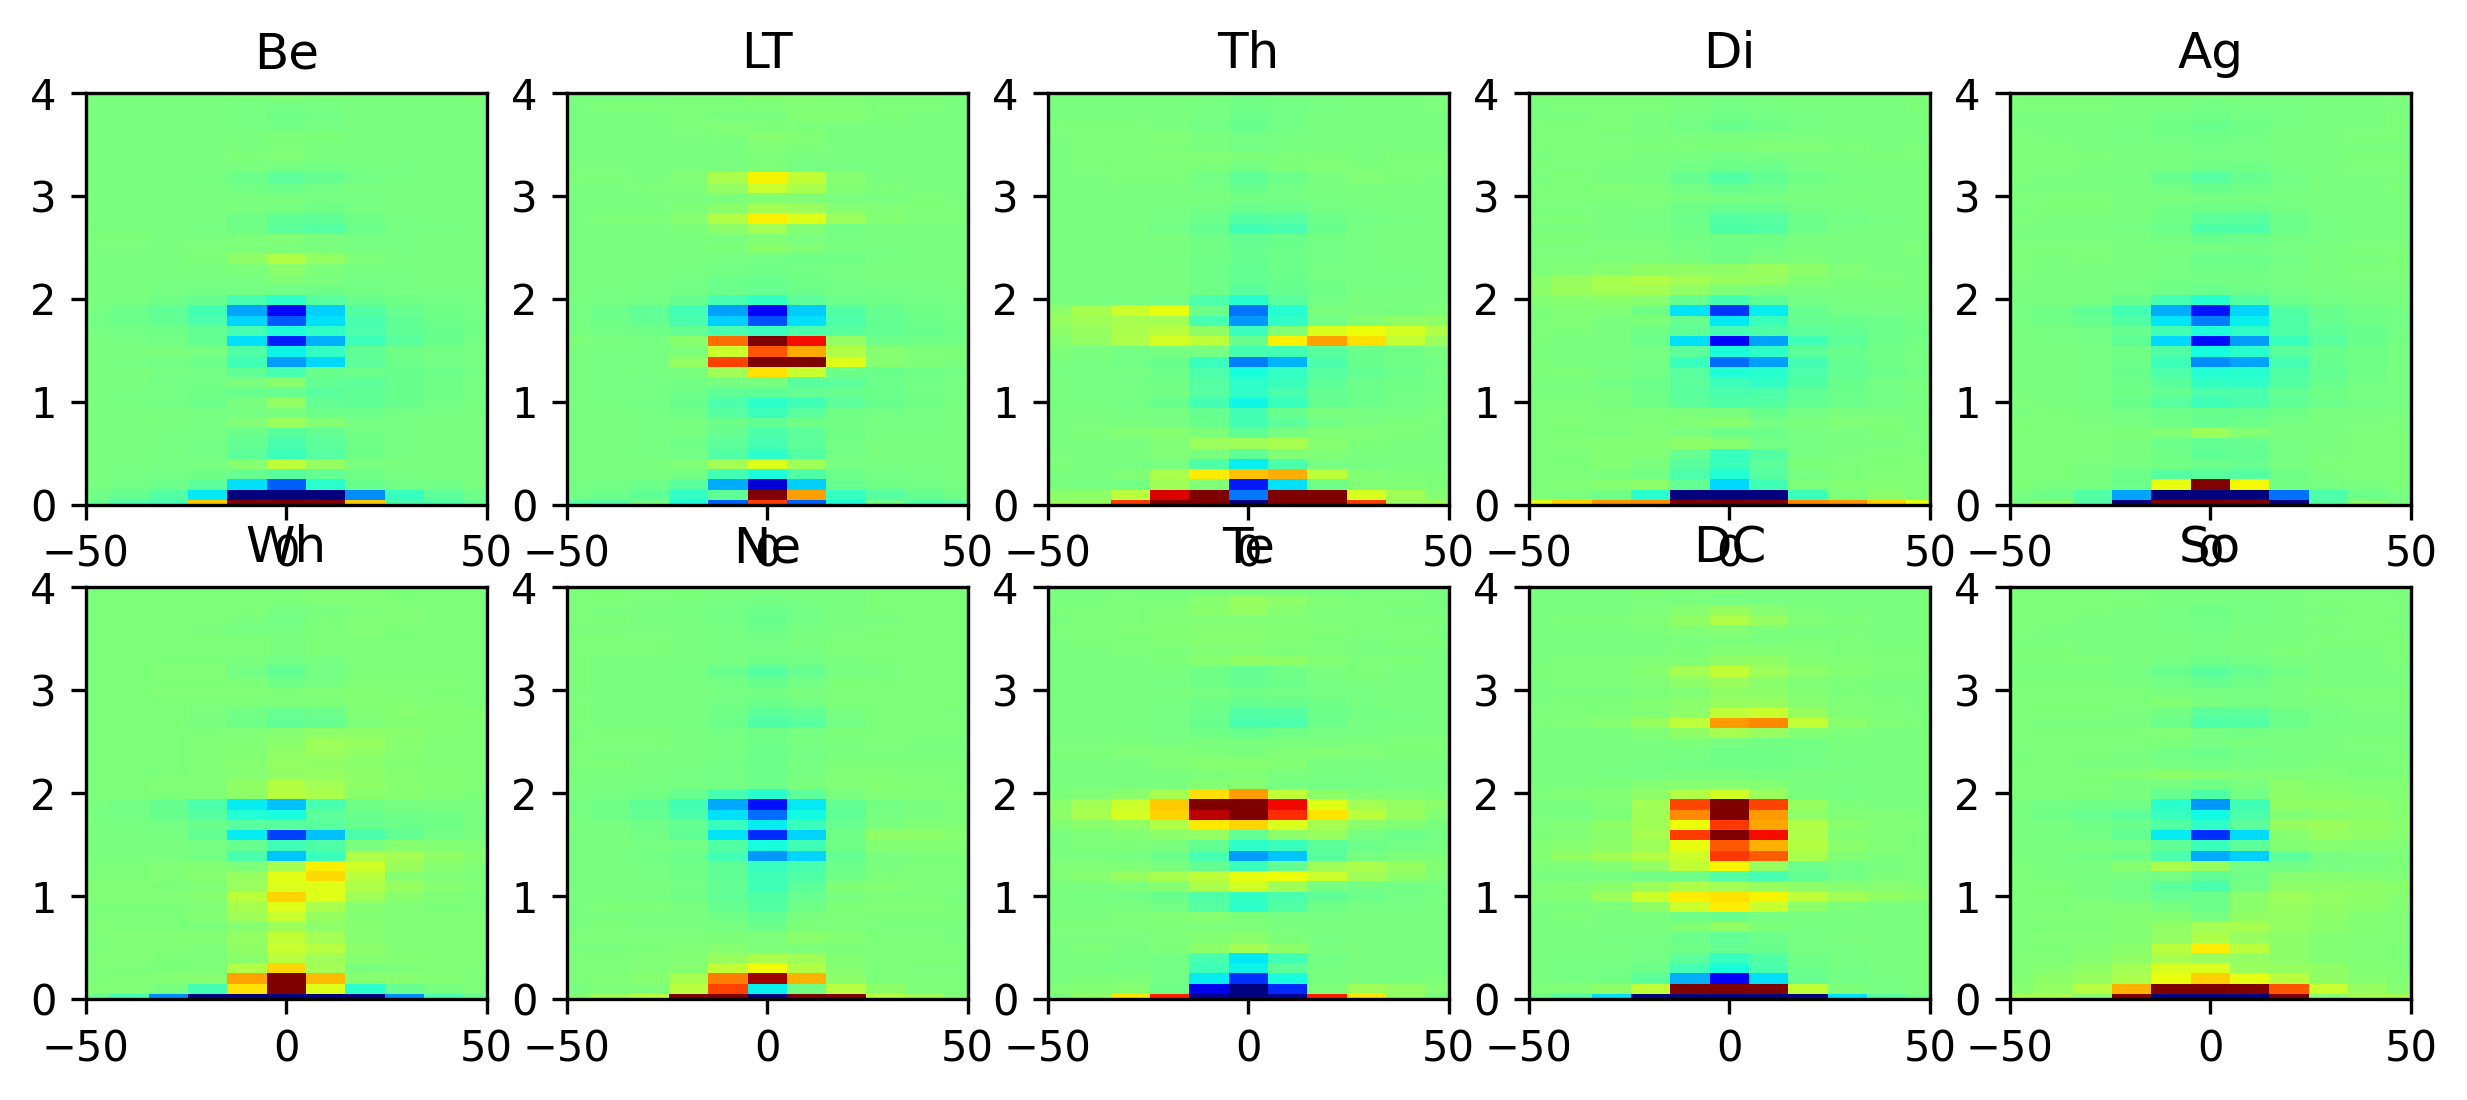

In [31]:
plt.figure(dpi=300, figsize= (10, 4))
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)
cmap = plt.get_cmap('jet')
                
for iplot, calltype in enumerate(callMPS):
    plt.subplot(2,5,1+iplot)
    plt.imshow(np.mean(callMPS[calltype], axis=0), interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)

    plt.ylim((0,4))
    plt.xlim((-50, 50))
    plt.clim((-200, 200))
    plt.title(calltype)
        

plt.savefig('/Users/frederictheunissen/Desktop/callTypeMPS.eps')

/*--------------------- Spectrograms for Be ---------------------------*/


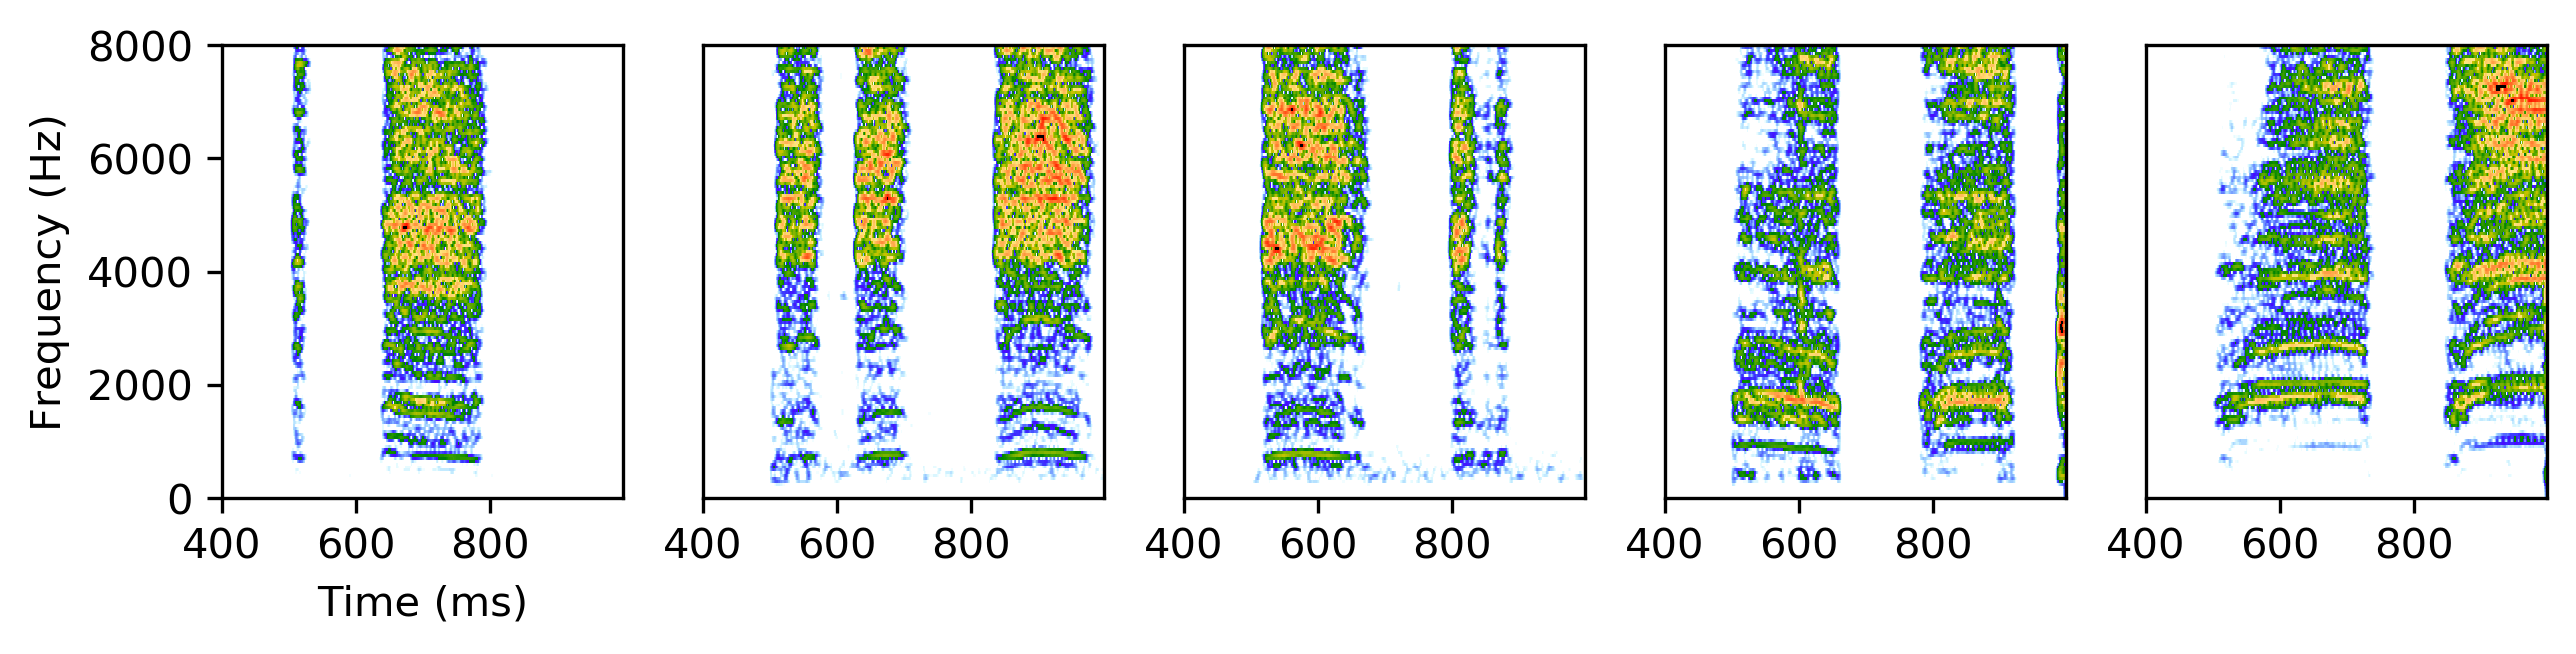

/*--------------------- Spectrograms for LT ---------------------------*/


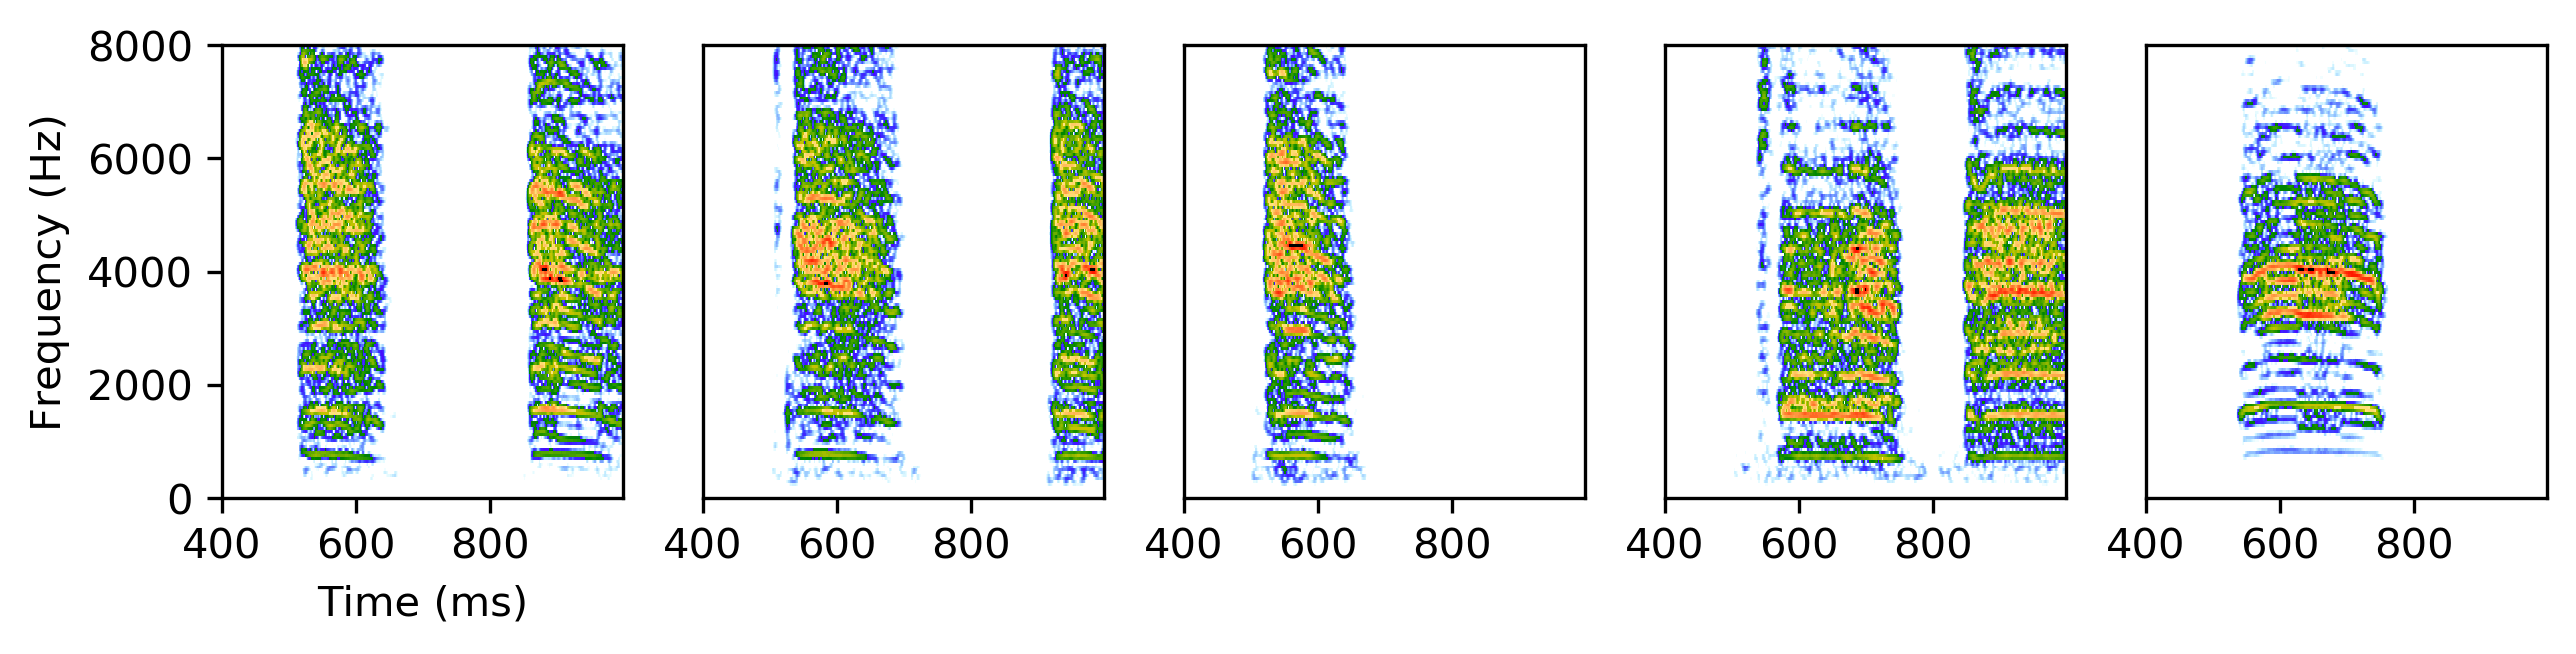

/*--------------------- Spectrograms for Th ---------------------------*/


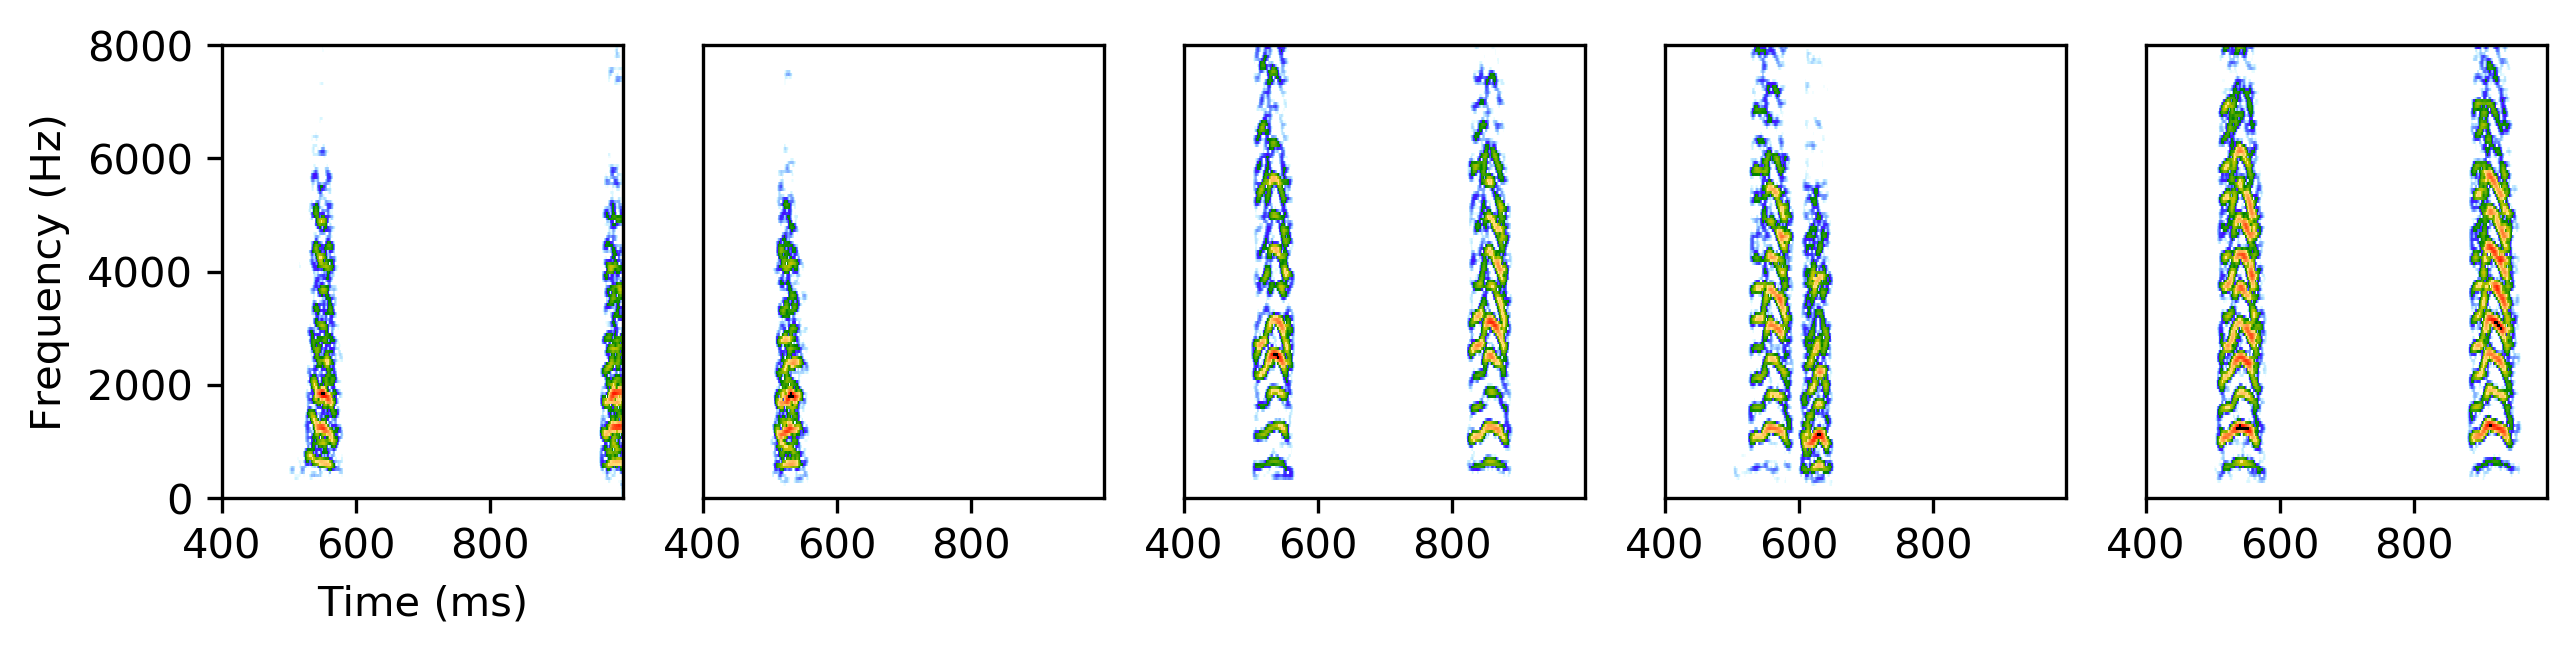

/*--------------------- Spectrograms for Di ---------------------------*/


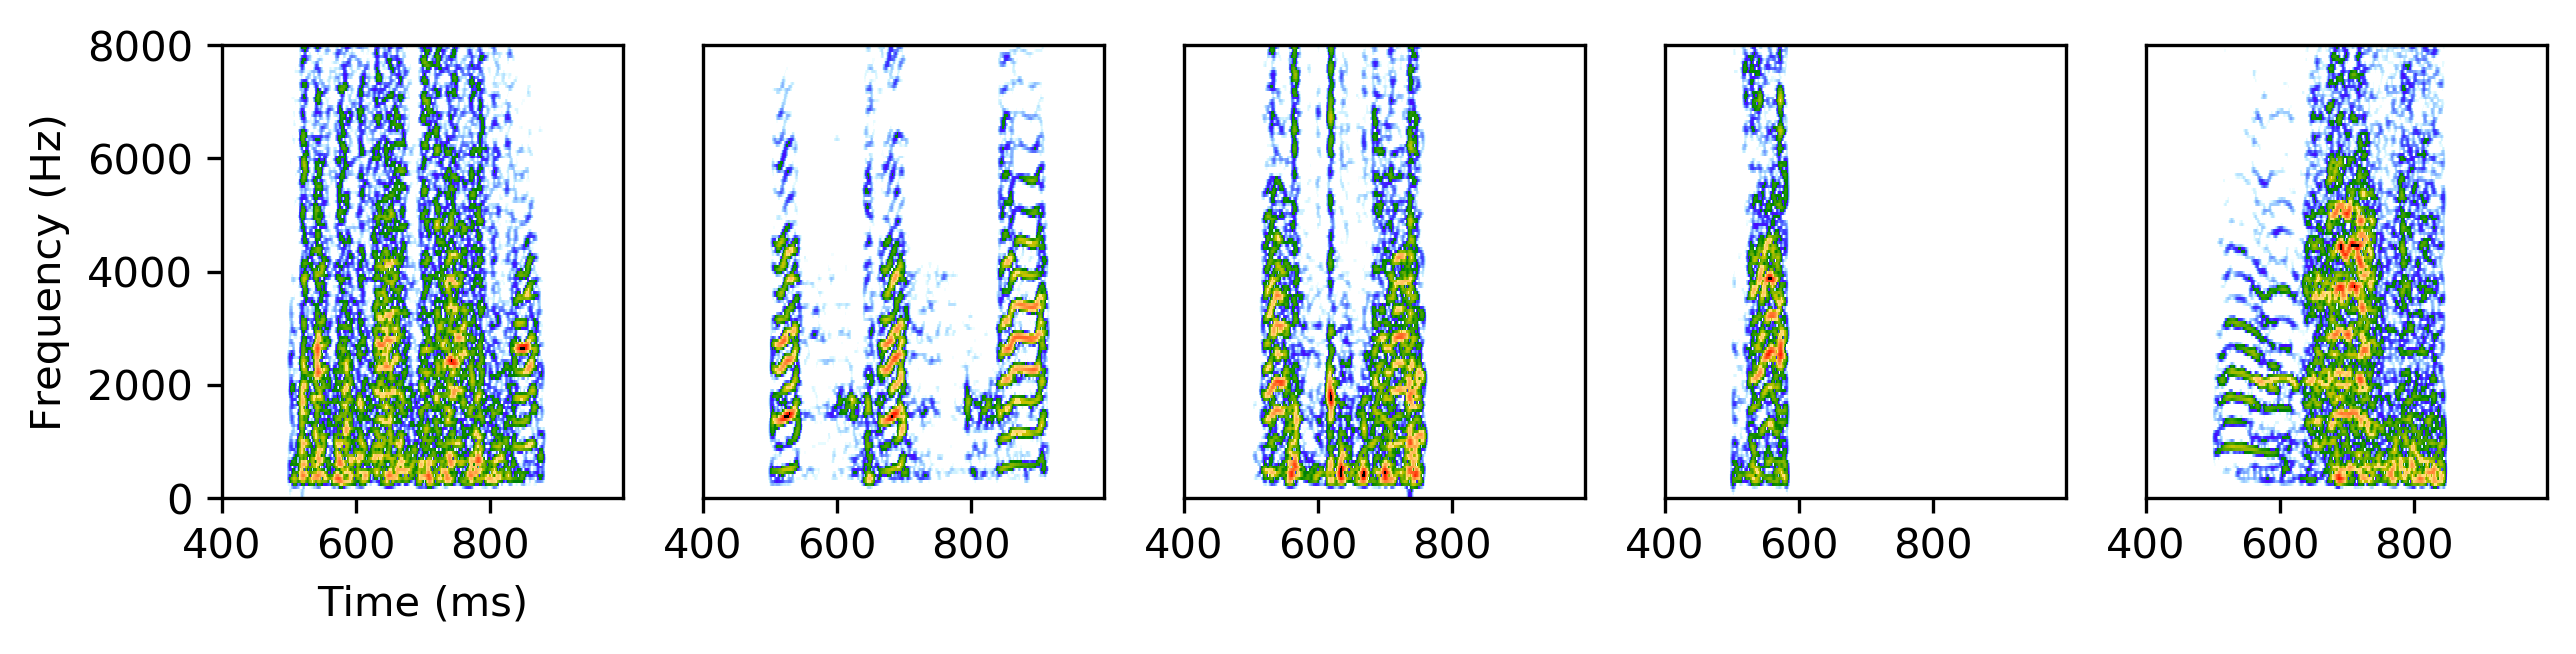

/*--------------------- Spectrograms for Ag ---------------------------*/


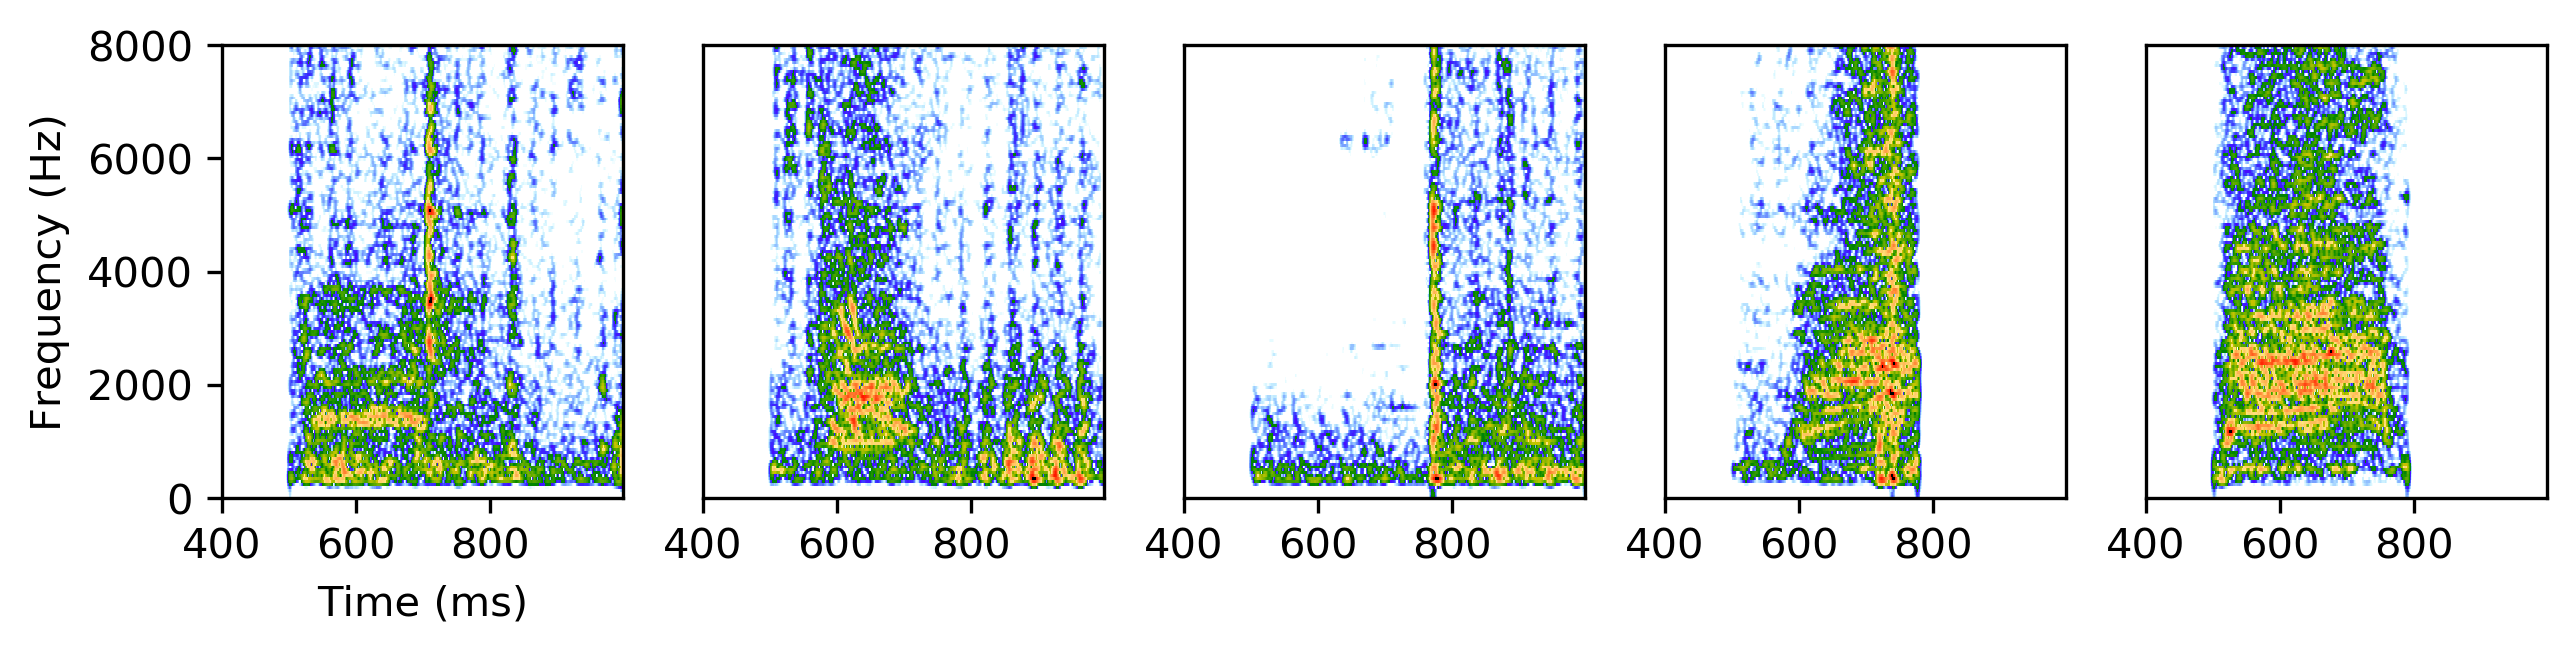

/*--------------------- Spectrograms for Wh ---------------------------*/


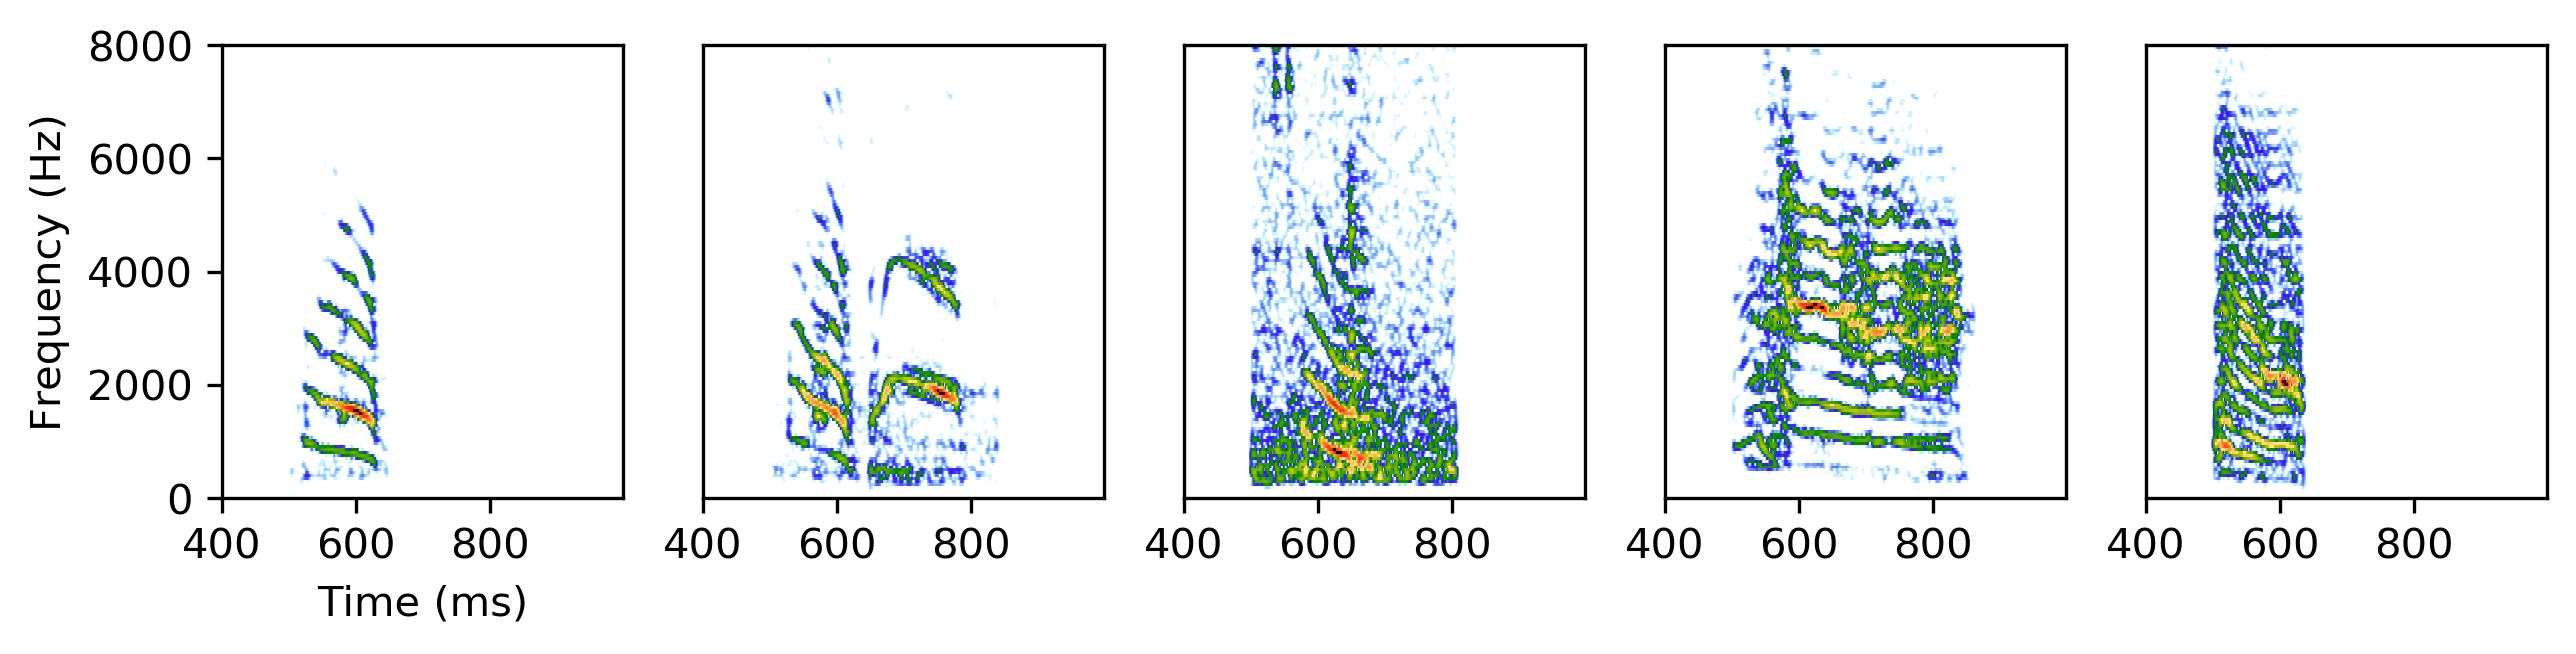

/*--------------------- Spectrograms for Ne ---------------------------*/


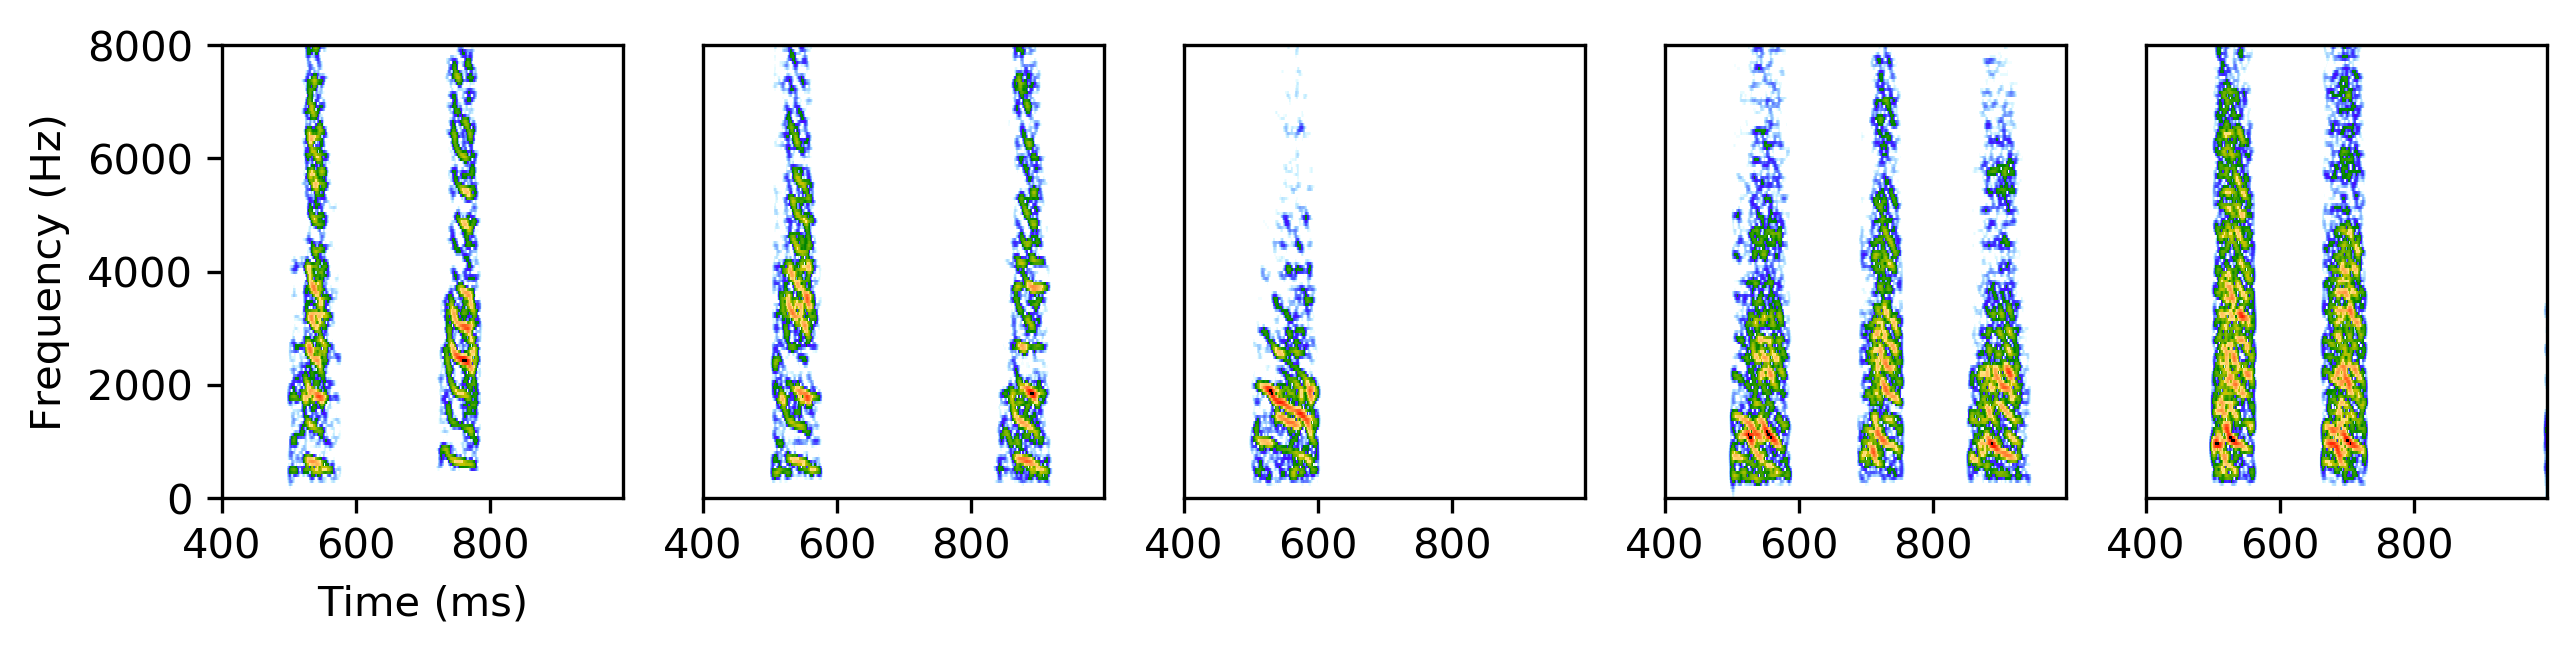

/*--------------------- Spectrograms for Te ---------------------------*/


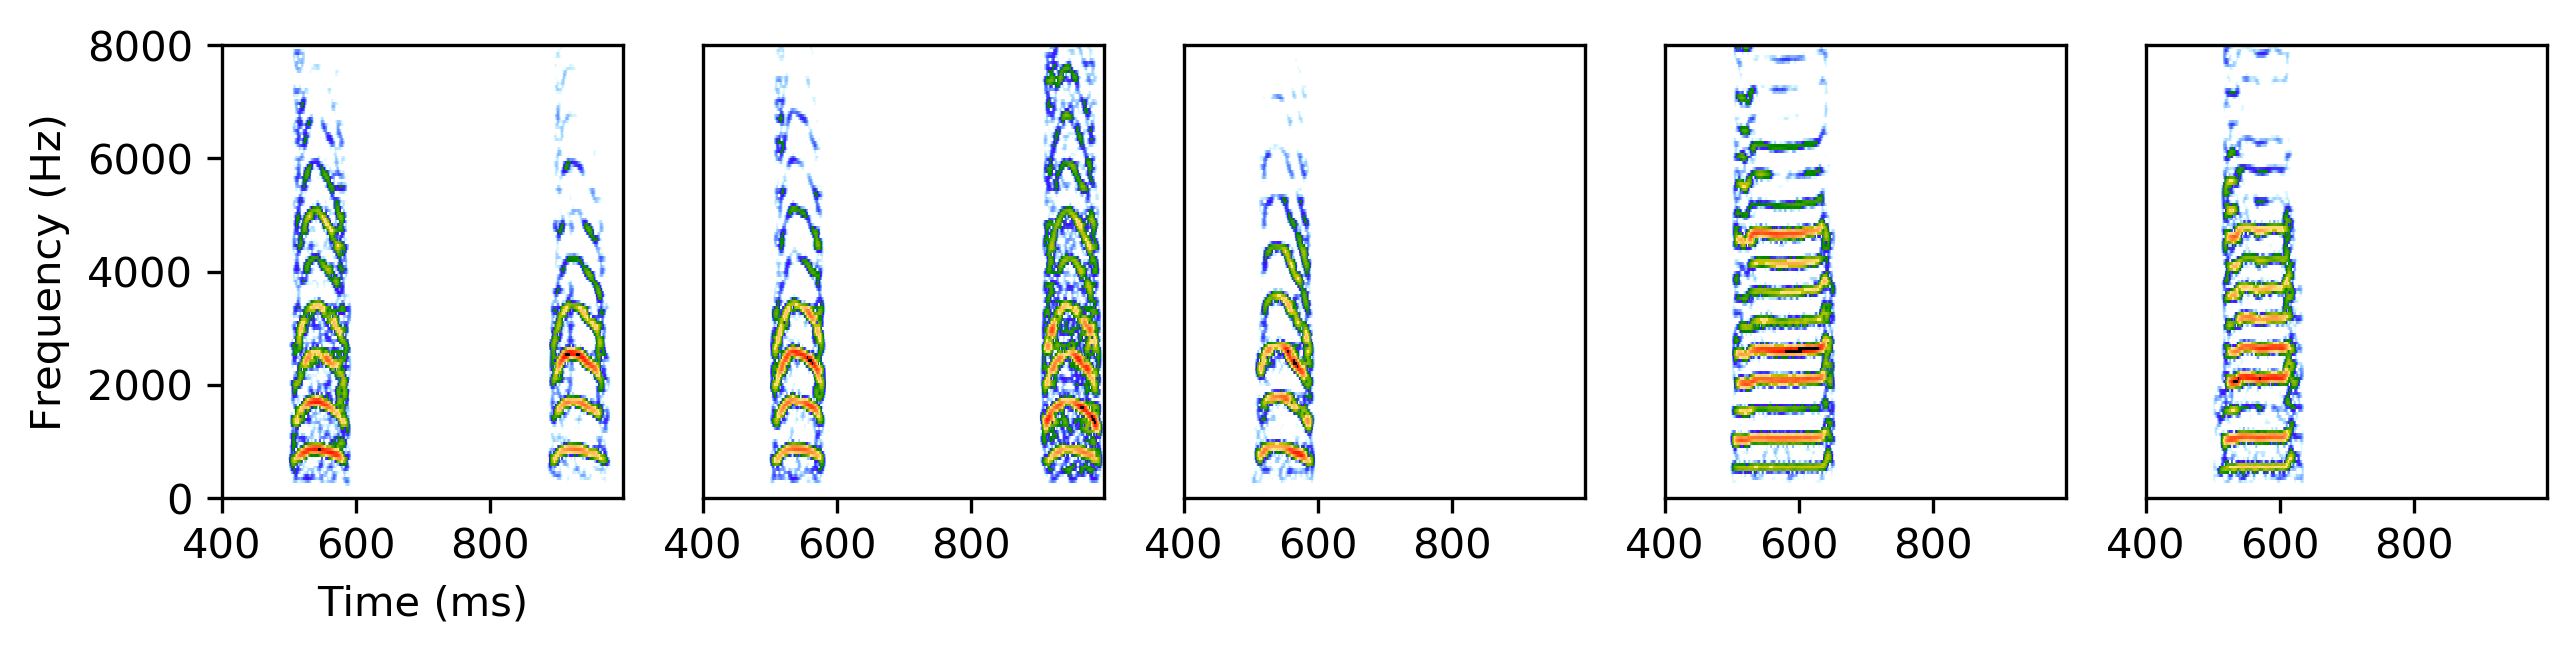

/*--------------------- Spectrograms for DC ---------------------------*/


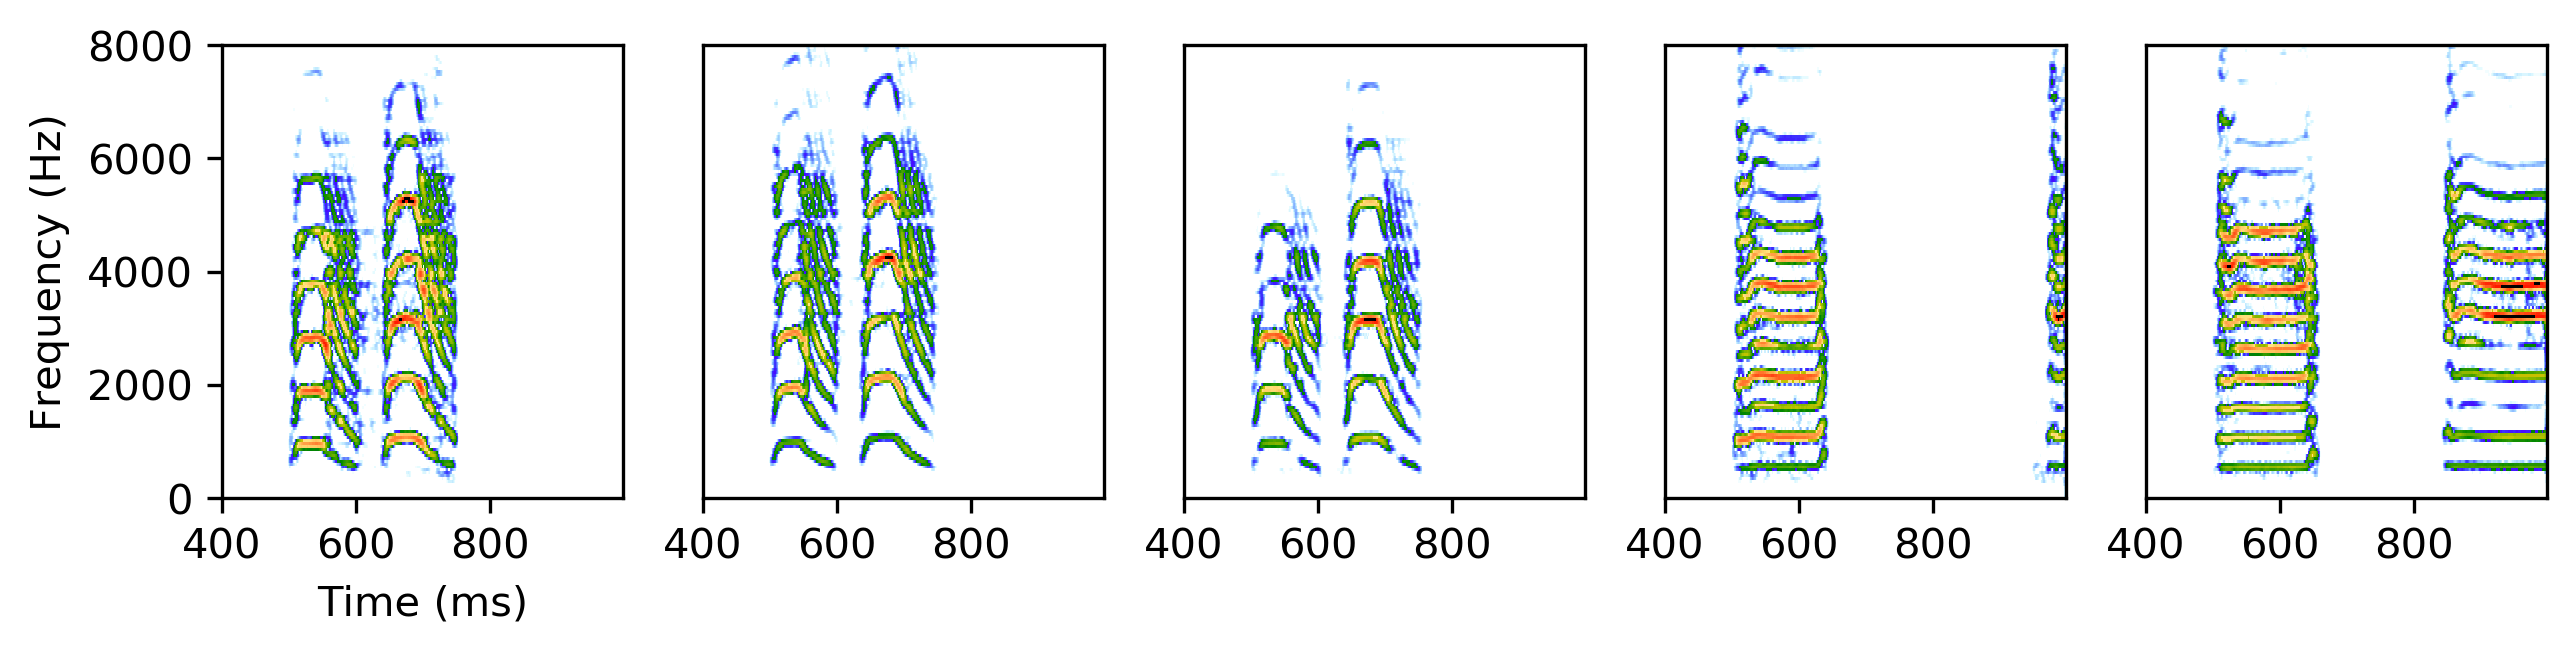

/*--------------------- Spectrograms for So ---------------------------*/


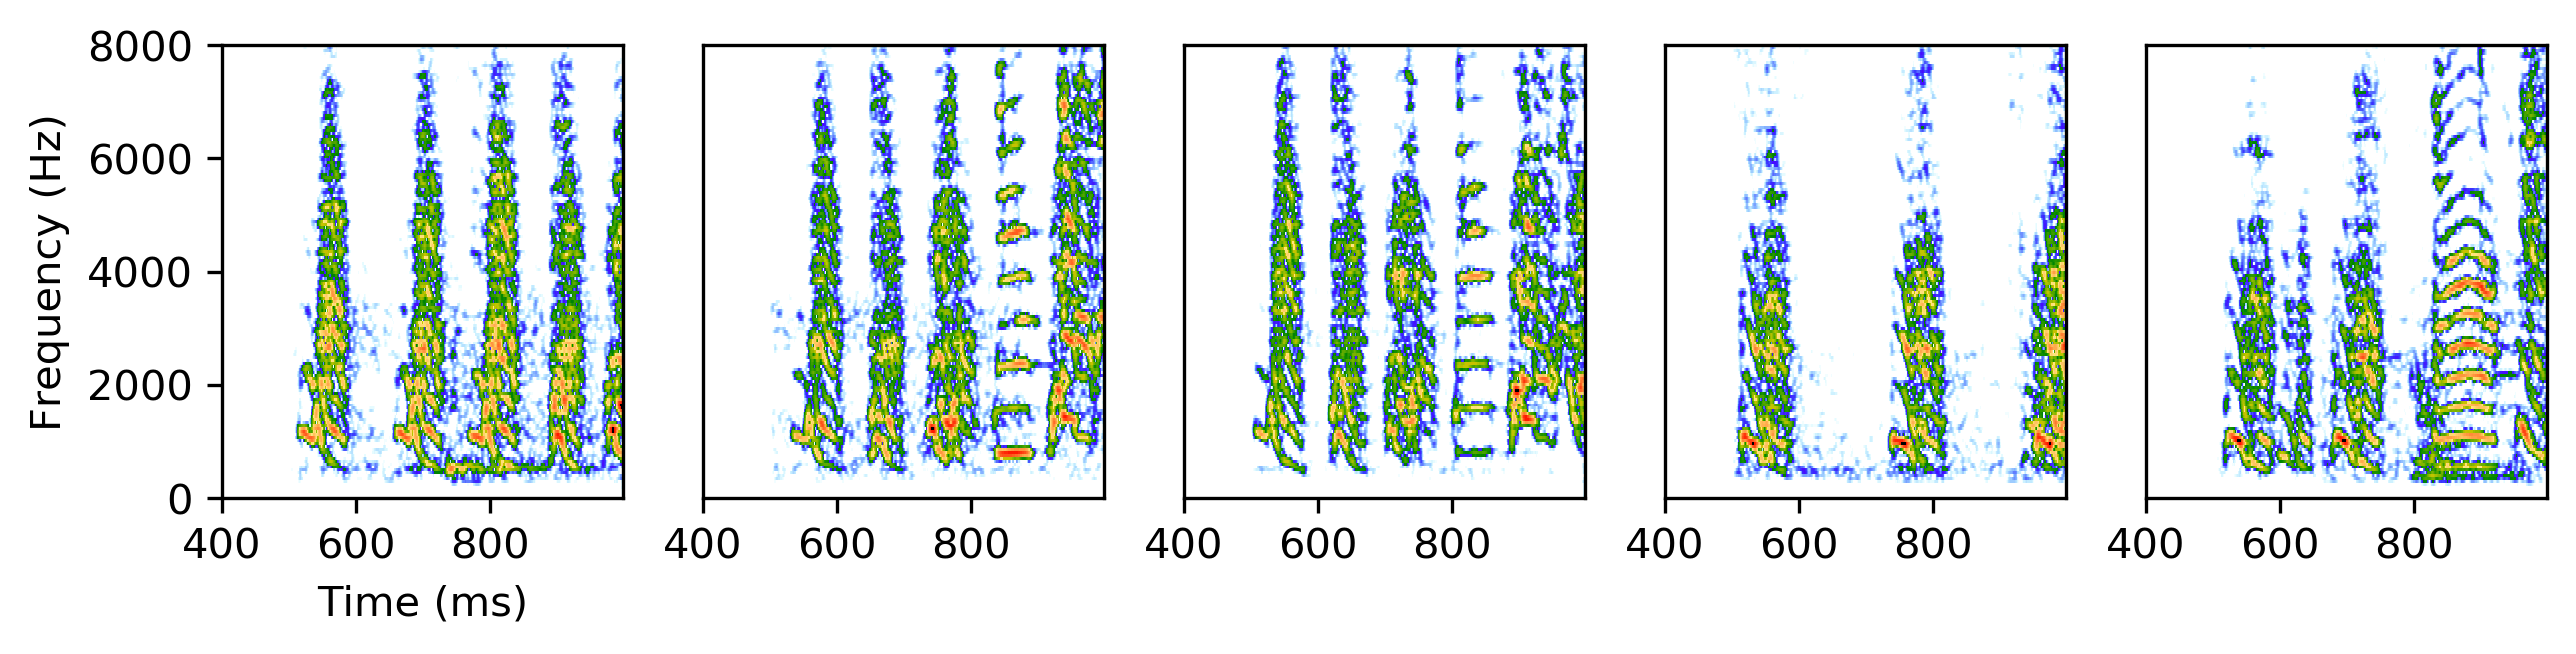

In [8]:
# Make plots of spectrograms to choose some for examples.
spec_colormap()   # defined in sound.py
cmap = plt.get_cmap('SpectroColorMap')
DBNOISE = 40
        
for calltype in callSpectro:
    print('/*--------------------- Spectrograms for %s ---------------------------*/' % calltype)
    plt.figure(dpi=300, figsize= (10, 2))
    for icall, callExample in enumerate(callSpectro[calltype]):
        ax = plt.subplot(1,5, icall+1)
        soundSpect = callExample[0]
        to = callExample[1]
        fo = callExample[2]
        if soundSpect.shape[0] == to.size:
            soundSpect = np.transpose(soundSpect)
        maxB = soundSpect.max()
        minB = maxB-DBNOISE
        soundSpect[soundSpect < minB] = minB
        minSpect = soundSpect.min()
        plt.imshow(soundSpect, extent = (to[0]*1000, to[-1]*1000, fo[0], fo[-1]), aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
        
        plt.ylim(0, 8000)
        plt.xlim(400, to[-1]*1000)
        if icall == 0 :
            plt.ylabel('Frequency (Hz)')
            plt.xlabel('Time (ms)')
        else:
            plt.yticks([])
            
        if icall == 4 :
            break
    plt.savefig('/Users/frederictheunissen/Desktop/callTypeSpectroColor%s.eps' % calltype)
    plt.show()
        
        

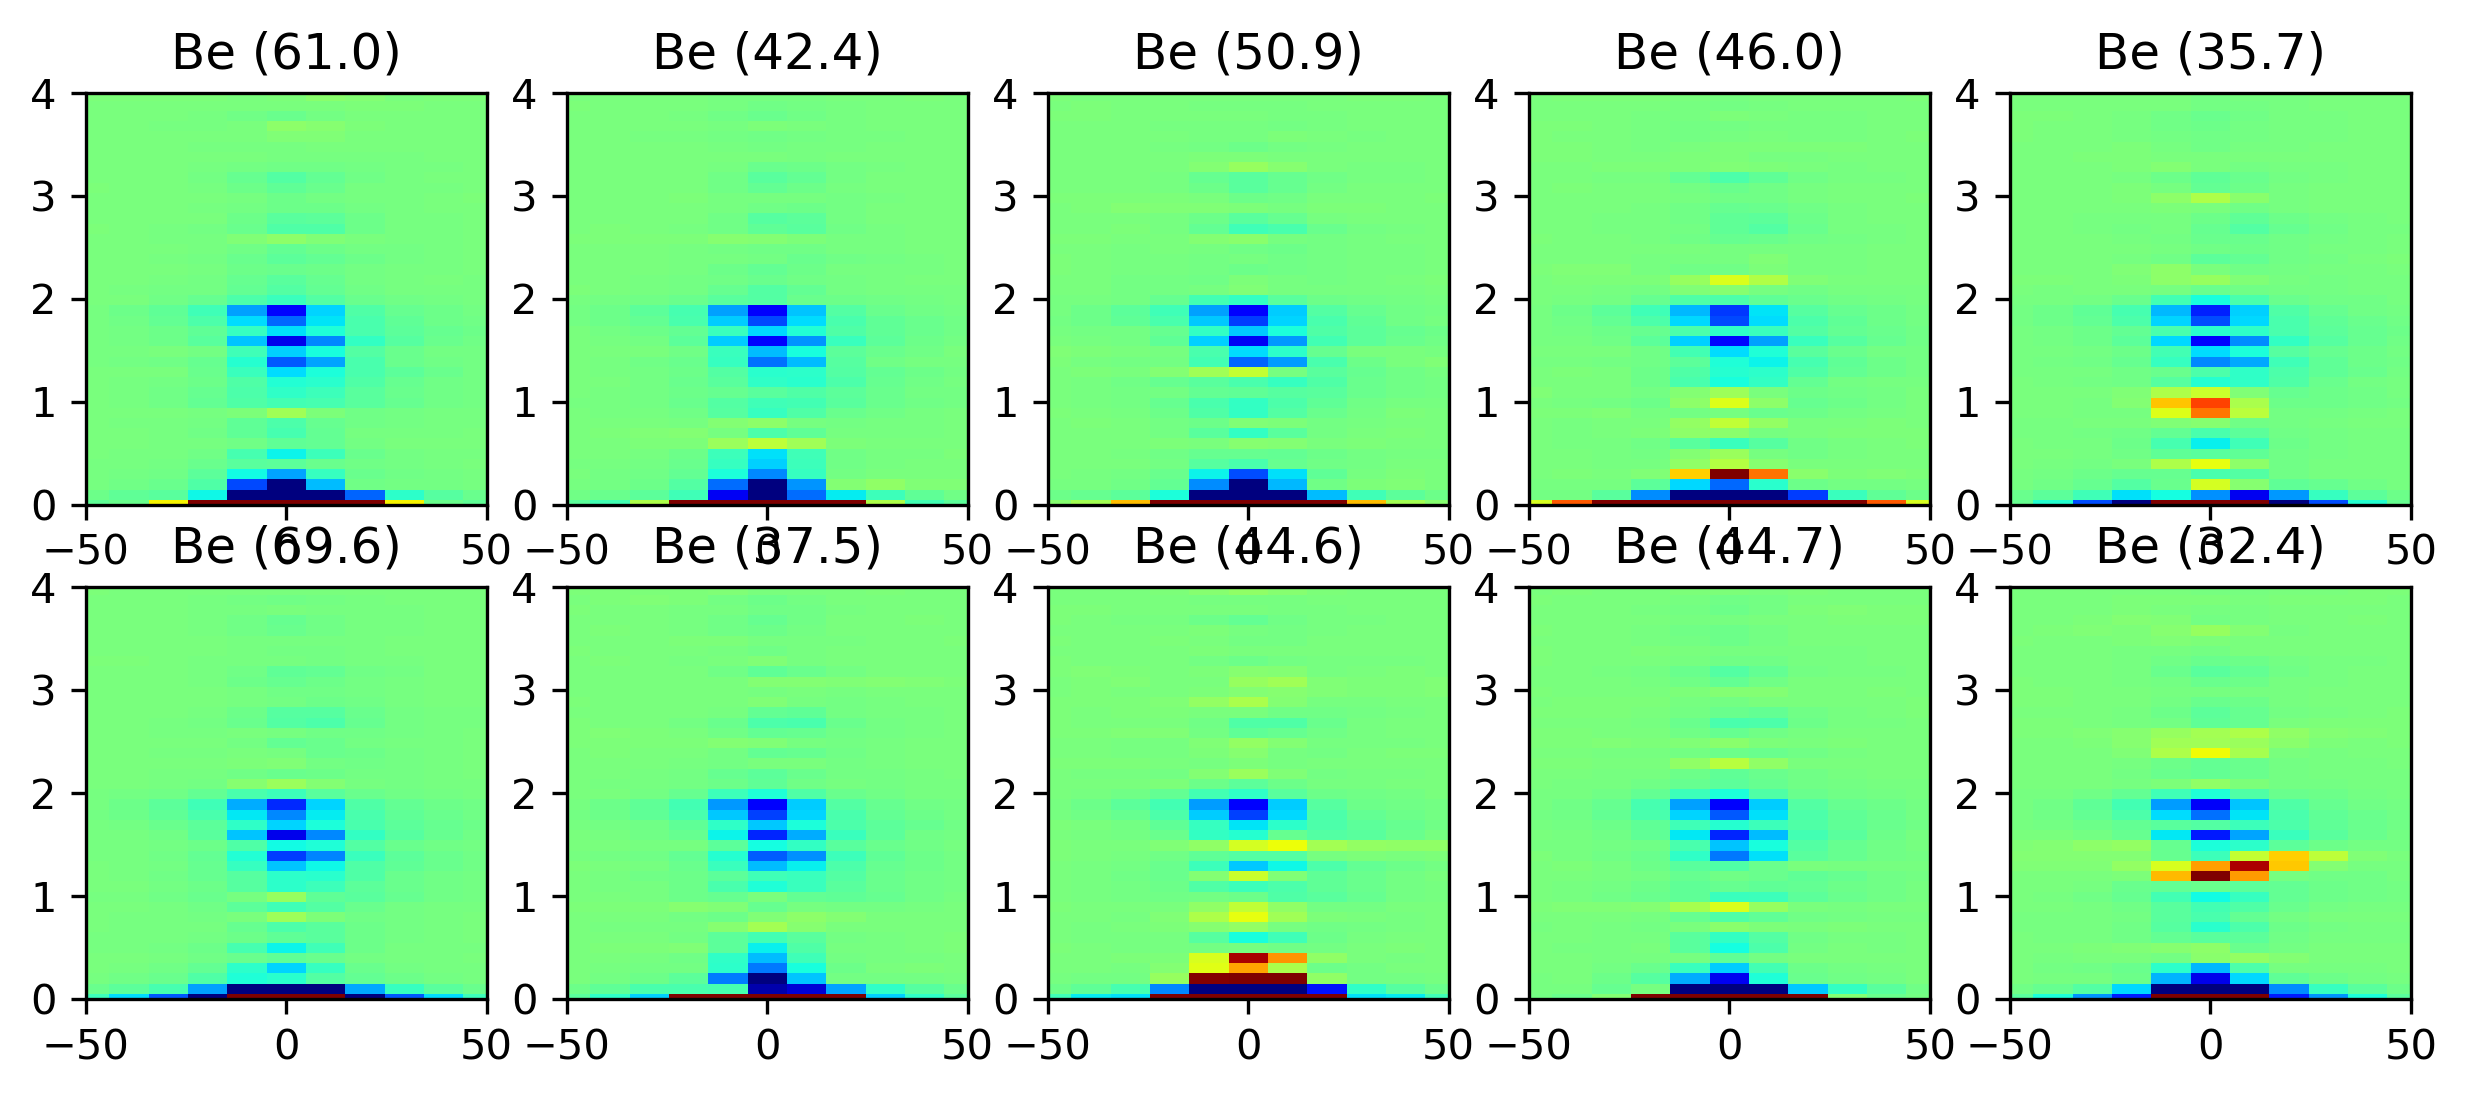

In [15]:
plt.figure(dpi=300, figsize= (10, 4))
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)
cmap = plt.get_cmap('jet')

iplot = 1
for icall, calltype in enumerate(callMPS):
    for mps in callMPS[calltype]:
        plt.subplot(2,5,iplot)
        plt.imshow(mps, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
        plt.ylim((0,4))
        plt.xlim((-50, 50))
        plt.clim((-200, 200))
        plt.title('%s (%.1f)' % (calltype, np.std(mps)))
        iplot += 1
        if iplot == 11:
            break
    if iplot == 11:
        break;

plt.savefig('/Users/frederictheunissen/Desktop/BeggingCallMPS.eps')
       

In [20]:
# Between and Within Covariances
indTLow = np.argwhere(wt>-50)[0][0]
indTHigh = np.argwhere(wt>50)[0][0]
indFLow = np.argwhere(wf>=0)[0][0]
indFHigh = np.argwhere(wf*1000>4)[0][0]

callMPSMeans = []
for calltype in callMPS:
    for i, mps in enumerate(callMPS[calltype]):
        if i == 0:
            mpsavg = np.copy(mps[indFLow:indFHigh, indTLow:indTHigh])
        else:
            mpsavg += mps[indFLow:indFHigh, indTLow:indTHigh]
    
    callMPSMeans.append((mpsavg/len(callMPS[calltype])).flatten())
    
betweenCov = np.cov(np.array(callMPSMeans).transpose())


withinCovCall = []
overallCovData = []
for icall, calltype in enumerate(callMPS):
    callMPSWithin = []
    for mps in callMPS[calltype]:
        mpstemp = np.copy(mps[indFLow:indFHigh, indTLow:indTHigh])
        callMPSWithin.append(mpstemp.flatten() - callMPSMeans[icall])
        overallCovData.append(mpstemp.flatten())
        
    withinCovCall.append(np.cov(np.array(callMPSWithin).transpose()))
    
withinCov = np.mean(withinCovCall, axis = 0)
overallCov = np.cov(np.array(overallCovData).transpose())

In [21]:
# Look at the DFA Space:
eigMatrix = np.matmul(np.linalg.pinv(withinCov, rcond = 0.0001, hermitian=True), betweenCov)
#eigMatrix = betweenCov
#eigMatrix = overallCov
eigVal, eigVect = np.linalg.eigh(eigMatrix)

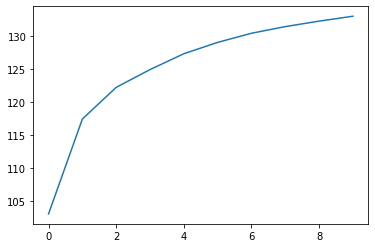

In [22]:
plt.plot(np.cumsum(np.abs(eigVal[0:10])))

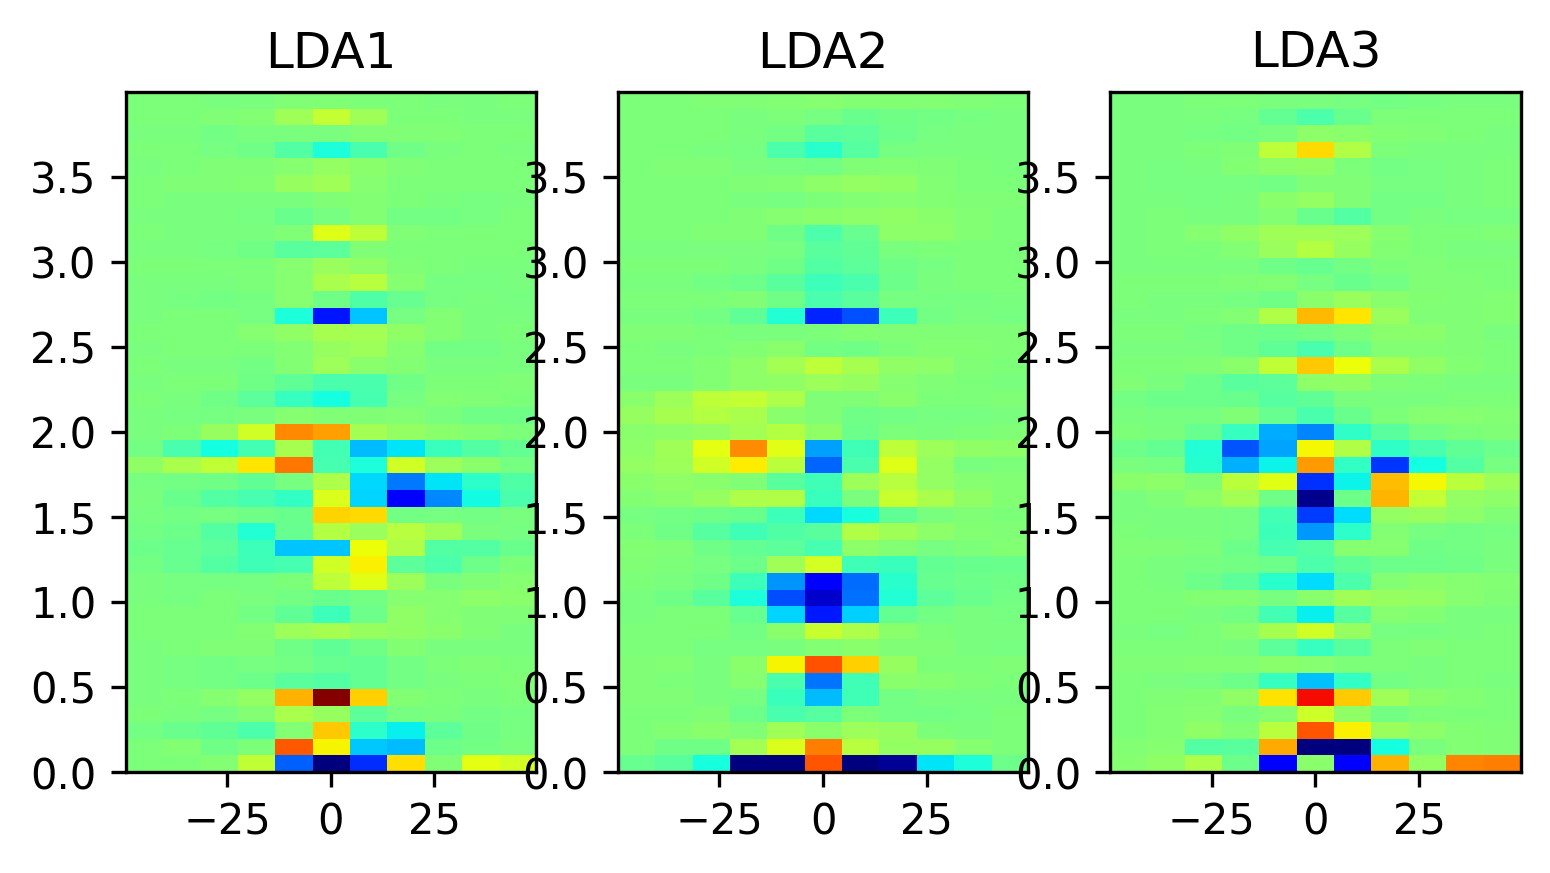

In [23]:
plt.figure(dpi=300, figsize= (6, 3))
ex = (wt[indTLow], wt[indTHigh-1], wf[indFLow]*1e3, wf[indFHigh-1]*1e3)
cmap = plt.get_cmap('jet')
                
for iplot in range(3):
    plt.subplot(1,3,1+iplot)
    plt.imshow(np.reshape(eigVect[:,iplot], mpstemp.shape), interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    plt.clim(-0.25,0.25)

    plt.title('LDA%d' % (iplot+1))
        
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


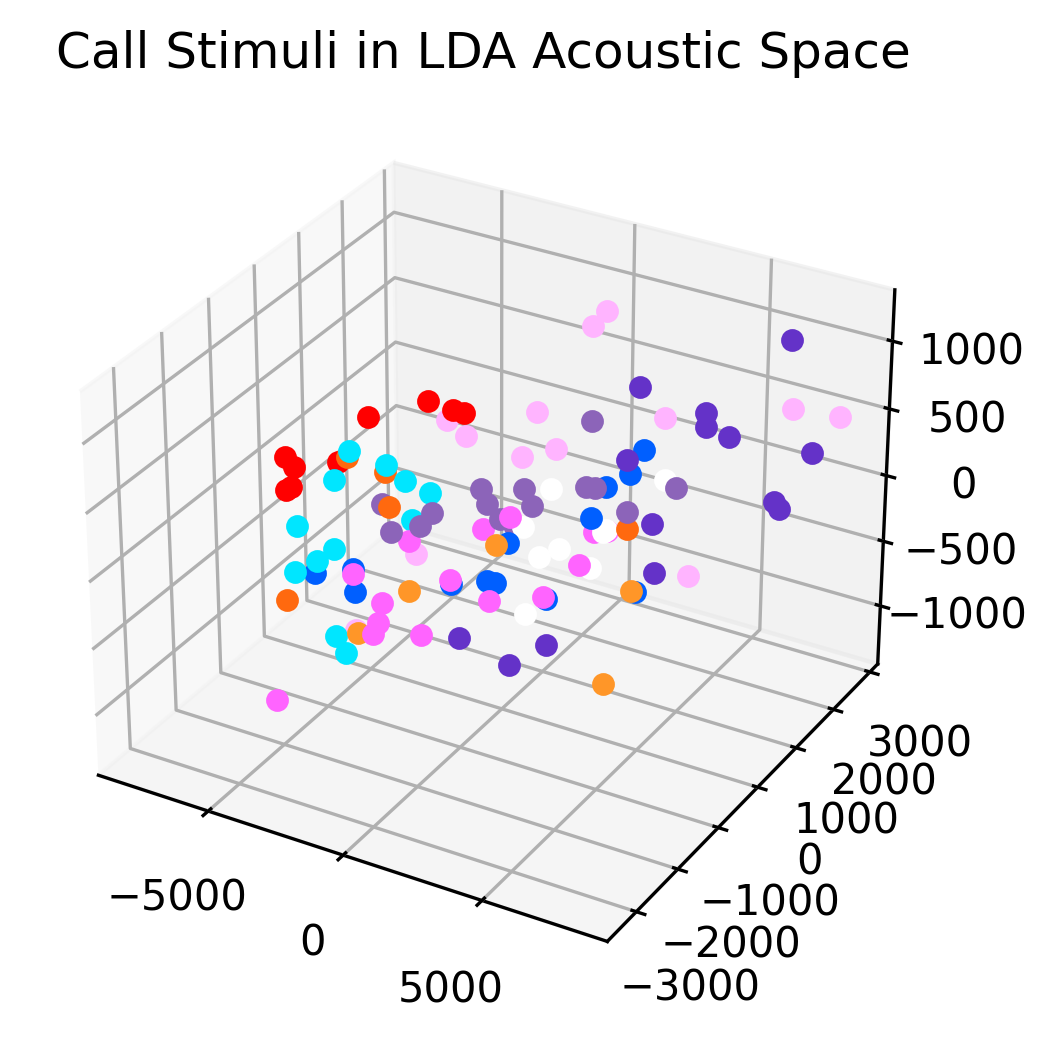

In [24]:
# Make a scatter plot to show call type centroids in PC space

callMPSLDA = {'Be': [], 'LT': [], 'Th': [], 
             'Di': [], 'Ag': [], 'Wh': [], 'Ne': [],
             'Te': [], 'DC': [], 'So': []}
   
for icall, calltype in enumerate(callMPS):
    for mps in callMPS[calltype]:
        mpstemp = mps[indFLow:indFHigh, indTLow:indTHigh]
        mpstemp = mpstemp.flatten()    
        # print(calltype, ':', np.std(mpstemp))
        callMPSLDA[calltype].append(np.array([np.dot(eigVect[:,0], mpstemp), np.dot(eigVect[:,1], mpstemp), np.dot(eigVect[:,2], mpstemp) ]))
        
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')
for calltype in callMPSLDA:
    for xyz in callMPSLDA[calltype]:
        ax.scatter(xyz[0], xyz[1], xyz[2], marker = 'o', color = callColor[calltype])
        
plt.title('Call Stimuli in LDA Acoustic Space')
        
plt.savefig('/Users/frederictheunissen/Desktop/callTypeLDA.eps')
    

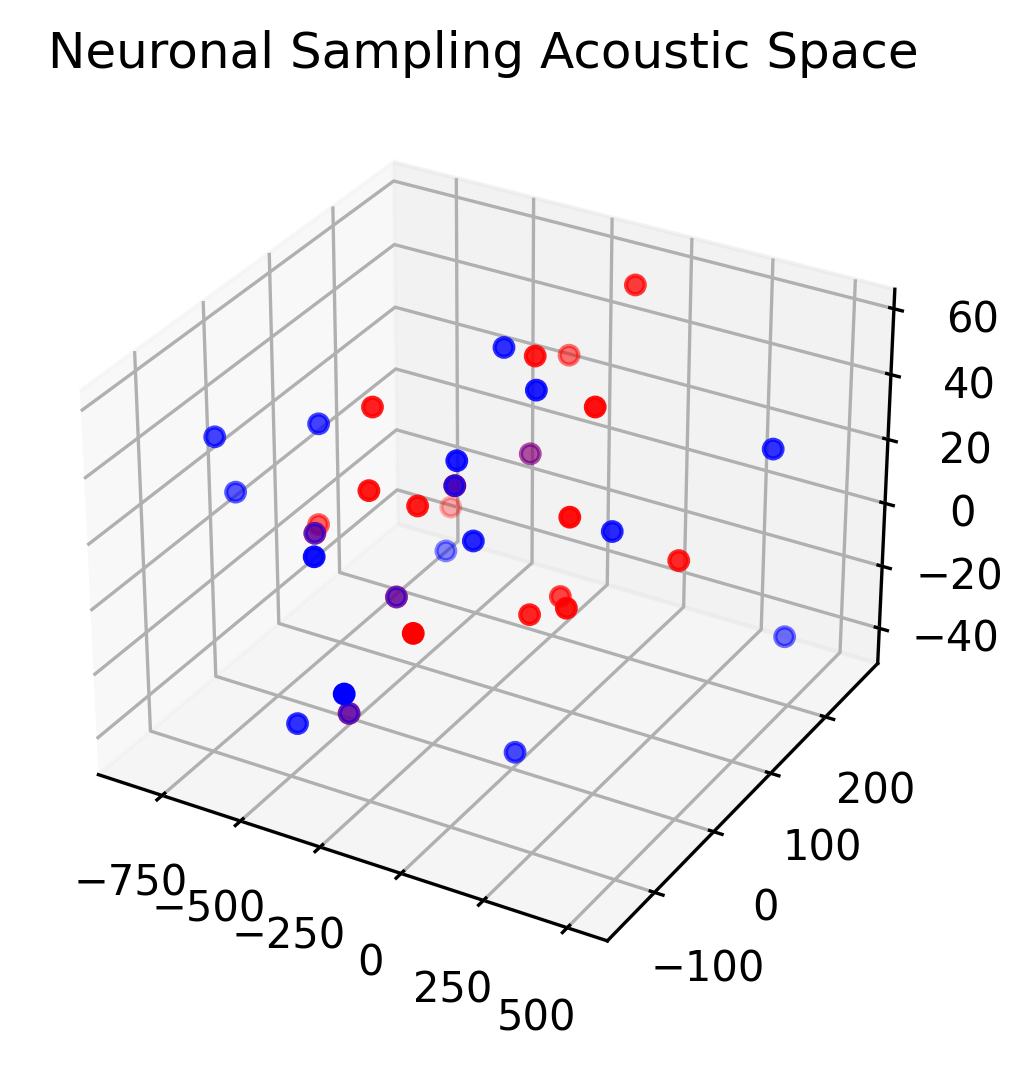

In [37]:
# Plot MTF of best and worst 20 Neurons in LDA space.

# Calculate the position of the best neurons
unitMTFLDABest = []
for unit in argList[indListMax]:
    indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
    mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
    x = np.dot(eigVect[:,0], mtf)/110
    y = np.dot(eigVect[:,1], mtf)/110
    z = np.dot(eigVect[:,2], mtf)/110
    unitMTFLDABest.append(np.array([x,y,z]))

unitMTFLDABest = np.vstack(unitMTFLDABest)

# Calculate the position of the worst neurons
unitMTFLDAWorst = []
for unit in argList[indListMin]:
    indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
    mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
    x = np.dot(eigVect[:,0], mtf)/110
    y = np.dot(eigVect[:,1], mtf)/110
    z = np.dot(eigVect[:,2], mtf)/110
    unitMTFLDAWorst.append(np.array([x,y,z]))

unitMTFLDAWorst = np.vstack(unitMTFLDAWorst)    
    
    
# Plot the data
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')
ax.scatter(unitMTFLDABest[:,0], unitMTFLDABest[:,1], unitMTFLDABest[:,2], marker = 'o', color='blue')
ax.scatter(unitMTFLDAWorst[:,0], unitMTFLDAWorst[:,1], unitMTFLDAWorst[:,2], marker = 'o', color='red')
    
plt.title('Neuronal Sampling Acoustic Space')

plt.savefig('/Users/frederictheunissen/Desktop/NeuronZLDA.pdf')


In [25]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform



In [26]:
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

In [28]:
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

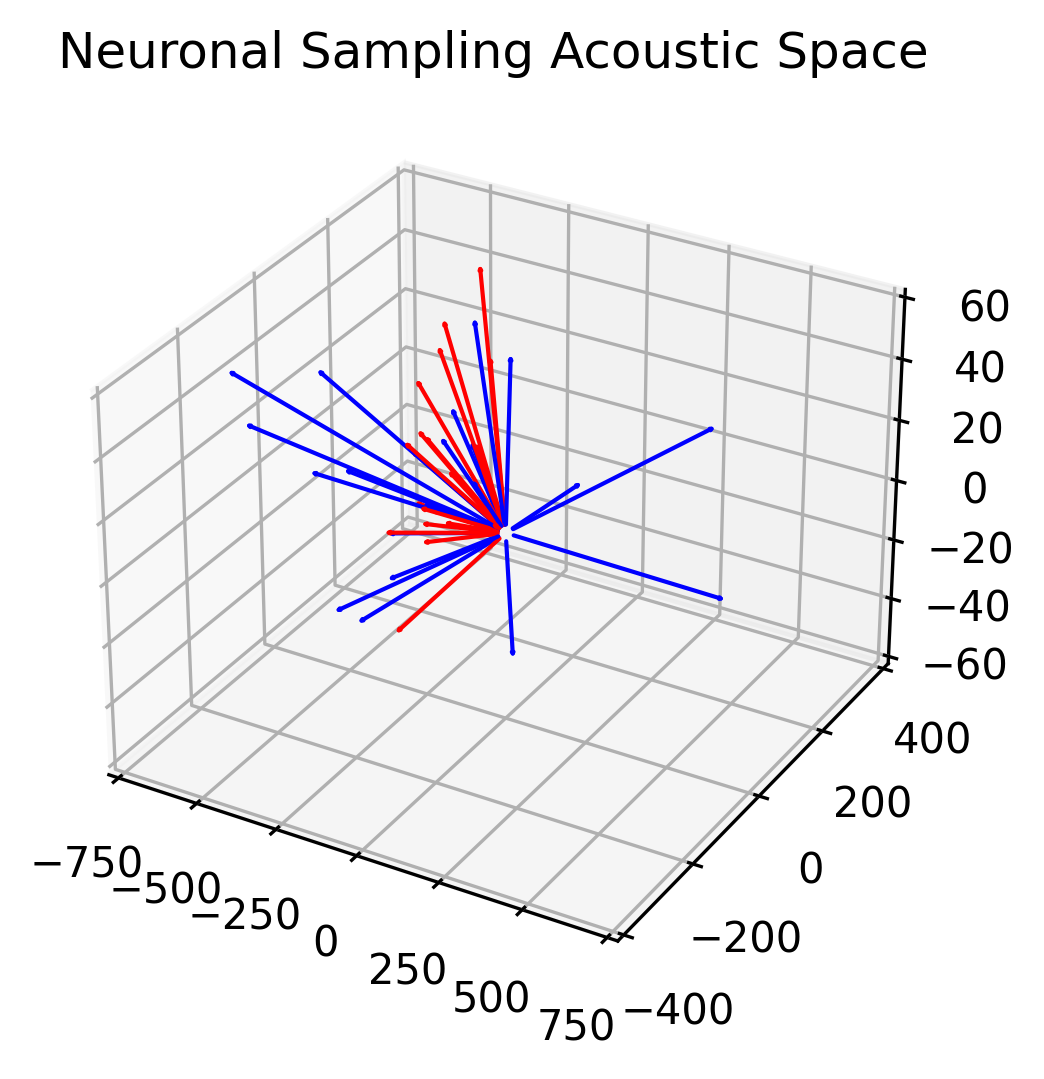

In [29]:
# Plot MTF of best and worst 20 Neurons in LDA space.

# Calculate the position of the best neurons
unitMTFLDABest = []
for unit in argList[indListMax]:
    indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
    mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
    x = np.dot(eigVect[:,0], mtf)/110
    y = np.dot(eigVect[:,1], mtf)/110
    z = np.dot(eigVect[:,2], mtf)/110
    unitMTFLDABest.append(np.array([x,y,z]))

unitMTFLDABest = np.vstack(unitMTFLDABest)

# Calculate the position of the worst neurons
unitMTFLDAWorst = []
for unit in argList[indListMin]:
    indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
    mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
    x = np.dot(eigVect[:,0], mtf)/110
    y = np.dot(eigVect[:,1], mtf)/110
    z = np.dot(eigVect[:,2], mtf)/110
    unitMTFLDAWorst.append(np.array([x,y,z]))

unitMTFLDAWorst = np.vstack(unitMTFLDAWorst)    
    
    
# Plot the data
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

for i in range(unitMTFLDABest.shape[0]):
    ax.arrow3D(0, 0, 0, unitMTFLDABest[i,0], unitMTFLDABest[i,1], unitMTFLDABest[i,2], arrowstyle="-|>", color='blue', lw=1)
    ax.arrow3D(0, 0, 0, unitMTFLDAWorst[1,0], unitMTFLDAWorst[i,1],unitMTFLDAWorst[i,2], arrowstyle="-|>", color='red', lw= 1)

ax.set_xlim(-750, 750)
ax.set_ylim(-400, 400)
ax.set_zlim(-60, 60)
plt.title('Neuronal Sampling Acoustic Space')

plt.savefig('/Users/frederictheunissen/Desktop/NeuronZLDALines.pdf')

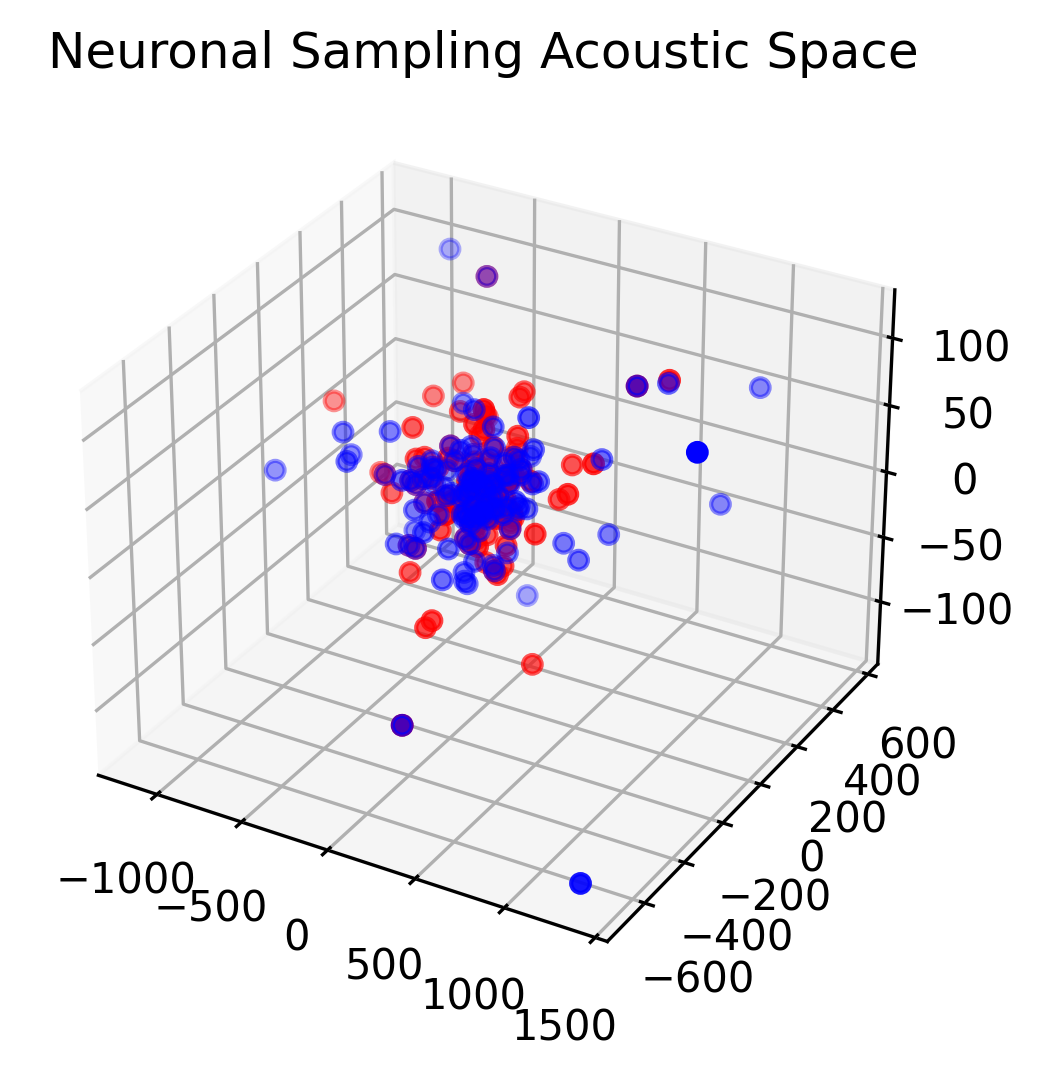

In [30]:
# Plot MTF of best and worst 20 Neurons in LDA space.

# Calculate the position of the best neurons
unitMTFLDABest = []
for unit in argList[indListMax]:
    indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
    mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
    x = np.dot(eigVect[:,0], mtf)/(110*stdz)
    y = np.dot(eigVect[:,1], mtf)/(110*stdz)
    z = np.dot(eigVect[:,2], mtf)/(110*stdz)
    unitMTFLDABest.append(np.array([x,y,z]))
    for ipc in range(5):
        mtf = np.copy(mpsTRGList[indUnit][ipc+1][indFLow:indFHigh, indTLow:indTHigh]).flatten()
        x = np.dot(eigVect[:,0], mtf)/(110*stdPC[ipc])
        y = np.dot(eigVect[:,1], mtf)/(110*stdPC[ipc])
        z = np.dot(eigVect[:,2], mtf)/(110*stdPC[ipc])
        unitMTFLDABest.append(np.array([x,y,z]))

unitMTFLDABest = np.vstack(unitMTFLDABest)

# Calculate the position of the worst neurons
unitMTFLDAWorst = []
for unit in argList[indListMin]:
    indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
    mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
    x = np.dot(eigVect[:,0], mtf)/(110*stdz)
    y = np.dot(eigVect[:,1], mtf)/(110*stdz)
    z = np.dot(eigVect[:,2], mtf)/(110*stdz)
    unitMTFLDAWorst.append(np.array([x,y,z]))
    for ipc in range(5):
        mtf = np.copy(mpsTRGList[indUnit][ipc+1][indFLow:indFHigh, indTLow:indTHigh]).flatten()
        x = np.dot(eigVect[:,0], mtf)/(110*stdPC[ipc])
        y = np.dot(eigVect[:,1], mtf)/(110*stdPC[ipc])
        z = np.dot(eigVect[:,2], mtf)/(110*stdPC[ipc])
        unitMTFLDAWorst.append(np.array([x,y,z]))

unitMTFLDAWorst = np.vstack(unitMTFLDAWorst)    
    
    
# Plot the data
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')
ax.scatter(unitMTFLDABest[:,0], unitMTFLDABest[:,1], unitMTFLDABest[:,2], marker = 'o', color='blue')
ax.scatter(unitMTFLDAWorst[:,0], unitMTFLDAWorst[:,1], unitMTFLDAWorst[:,2], marker = 'o', color='red')
    
plt.title('Neuronal Sampling Acoustic Space')

plt.savefig('/Users/frederictheunissen/Desktop/NeuronPCLDA.pdf')

In [31]:
print('Vol Best', np.power(np.prod(unitMTFLDABest.max(axis=0)-unitMTFLDABest.min(axis=0)),1/3))
print('Vol Worst', np.power(np.prod(unitMTFLDAWorst.max(axis=0)-unitMTFLDAWorst.min(axis=0)),1/3))

Vol Best 926.4976004159404
Vol Worst 692.573042540439


In [32]:
np.linalg.det(np.cov(unitMTFLDABest.transpose()))

2211186572989.2144

In [33]:
# Read data files 
inPathH = rootPath+dataPath+'summarySel.pkl'
fileInH = open(inPathH,"rb")
dfSummaryH = pk.load(fileInH)
fileInH.close()

# Add a field called site_unit to match what is in argList
dfSummaryH['site_unit'] = dfSummaryH['site']+ '_' + dfSummaryH['unit']

In [34]:
# This volume uses only the z-score

volumeLDA = np.zeros((len(argList),))

for ilist, unitList in enumerate(argList):
    unitMTFLDA = []
    for unit in unitList:
        indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
        mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
        x = np.dot(eigVect[:,0], mtf)/110
        y = np.dot(eigVect[:,1], mtf)/110
        z = np.dot(eigVect[:,2], mtf)/110
        unitMTFLDA.append(np.array([x,y,z]))
        
    unitMTFLDA = np.vstack(unitMTFLDA)
    
    # Two ideas for volume:  the determinant of the covariance matrix or the power of max-min
    volumeLDA[ilist] = np.power(np.prod(unitMTFLDA.max(axis=0)-unitMTFLDA.min(axis=0)),1/3)
    # volumeLDA[ilist] = np.linalg.det(np.cov(unitMTFLDA.transpose()))
    


In [35]:
# This volume also uses the PC's

volumeLDA = np.zeros((len(argList),))
noiseGroup = np.zeros((len(argList),))
selHGroup = np.zeros((len(argList)))
selzGroup = np.zeros((len(argList)))

for ilist, unitList in enumerate(argList):
    unitMTFLDA = []
    noiseList = 0
    selHList = 0
    selzList = 0
    for unit in unitList:
        indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
        mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
        x = np.dot(eigVect[:,0], mtf)/(110*stdz)
        y = np.dot(eigVect[:,1], mtf)/(110*stdz)
        z = np.dot(eigVect[:,2], mtf)/(110*stdz)
        unitMTFLDA.append(np.array([x,y,z]))
        noiseList += neuralNoise[indUnit]
        selHList += selH[indUnit]
        selzList += dfSummaryH['selInd'][dfSummaryH['site_unit']==unit].values[0]
        for ipc in range(5):
            mtf = np.copy(mpsTRGList[indUnit][ipc+1][indFLow:indFHigh, indTLow:indTHigh]).flatten()
            x = np.dot(eigVect[:,0], mtf)/(110*stdPC[ipc])
            y = np.dot(eigVect[:,1], mtf)/(110*stdPC[ipc])
            z = np.dot(eigVect[:,2], mtf)/(110*stdPC[ipc])
            unitMTFLDA.append(np.array([x,y,z]))
        
    unitMTFLDA = np.vstack(unitMTFLDA)
    
    # Two ideas for volume:  the determinant of the covariance matrix or the power of max-min
    #volumeLDA[ilist] = np.power(np.prod(unitMTFLDA.max(axis=0)-unitMTFLDA.min(axis=0)),1/3)
    volumeLDA[ilist] = np.linalg.det(np.cov(unitMTFLDA.transpose()))
    noiseGroup[ilist] = noiseList/len(unitList)
    selHGroup[ilist] = selHList/len(unitList)
    selzGroup[ilist] = selzList/len(unitList)

In [40]:
def bivariateReg(x, y, xlabel = 'x', ylabel = 'y', xlim = [], ylim = []):
    # Performs a bivariate regression, plots the line and stats.

    from random import sample
    from scipy.stats import f

    fig = plt.figure(figsize=(4,4), dpi=300)
    ax = plt.subplot()
    
    # Force x, y into numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    if xlim == []:
        xlim = (x.min(), x.max())
    if ylim == []:
        ylim = (y.min(), y.max())

    n = len(x)  # Data size

    # We are plotting a subset of the data
    if n > 1000 :
        selInd = sample(range(n), 1000)
    else:
        selInd = range(n)
        
    ax.scatter(x[selInd], y[selInd], s=1, color='grey', marker = ',')
        
    # fit a linear curve an estimate its y-values and their error.
    a, b = np.polyfit(x, y, deg=1)

    # Calculate error and statistics
    sse = np.sum((y-(a*x+b))**2)
    xmean = np.mean(x)
    ssx = np.sum((x - xmean)**2)
    sst = np.sum((y-np.mean(y))**2)
    syx = np.sqrt(sse/(n-2))
    sy  = np.sqrt(sst/(n-1))
    r2adj = 1. - syx**2/sy**2
    fval = (sst-sse)/syx**2
    pval = 1. - f.cdf(fval, dfn=1, dfd=n-2)  # This is not quite correct.

    # Plot the regression line and error bars for the subset of points (to avoid clutter)
    xsel = x[selInd]
    ysel = y[selInd]
    indSort = np.argsort(xsel)
    xsel = xsel[indSort]
    ysel = ysel[indSort]
    
    y_est = a * xsel + b
    y_err = syx * np.sqrt(1/n + ((xsel - xmean)**2 / ssx) )


    ax.plot(xsel, y_est, '-')
    ax.fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

    ax.set( xlim= xlim,
        ylim= ylim,
        ylabel=ylabel,
        xlabel=xlabel,
        title='%s vs %s, R2 = %.2f, p = %.3g' % (ylabel, xlabel, r2adj, pval))

    # fig.colorbar(im_, ax=ax)
    plt.savefig('/Users/frederictheunissen/Desktop/scatter%s%s.eps' % (xlabel, ylabel))
    return r2adj, fval, pval, sse, sst

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


R2= 0.09708196841929917 F(1, 79 )= 8.750543585214825 p= 0.004081787820817362


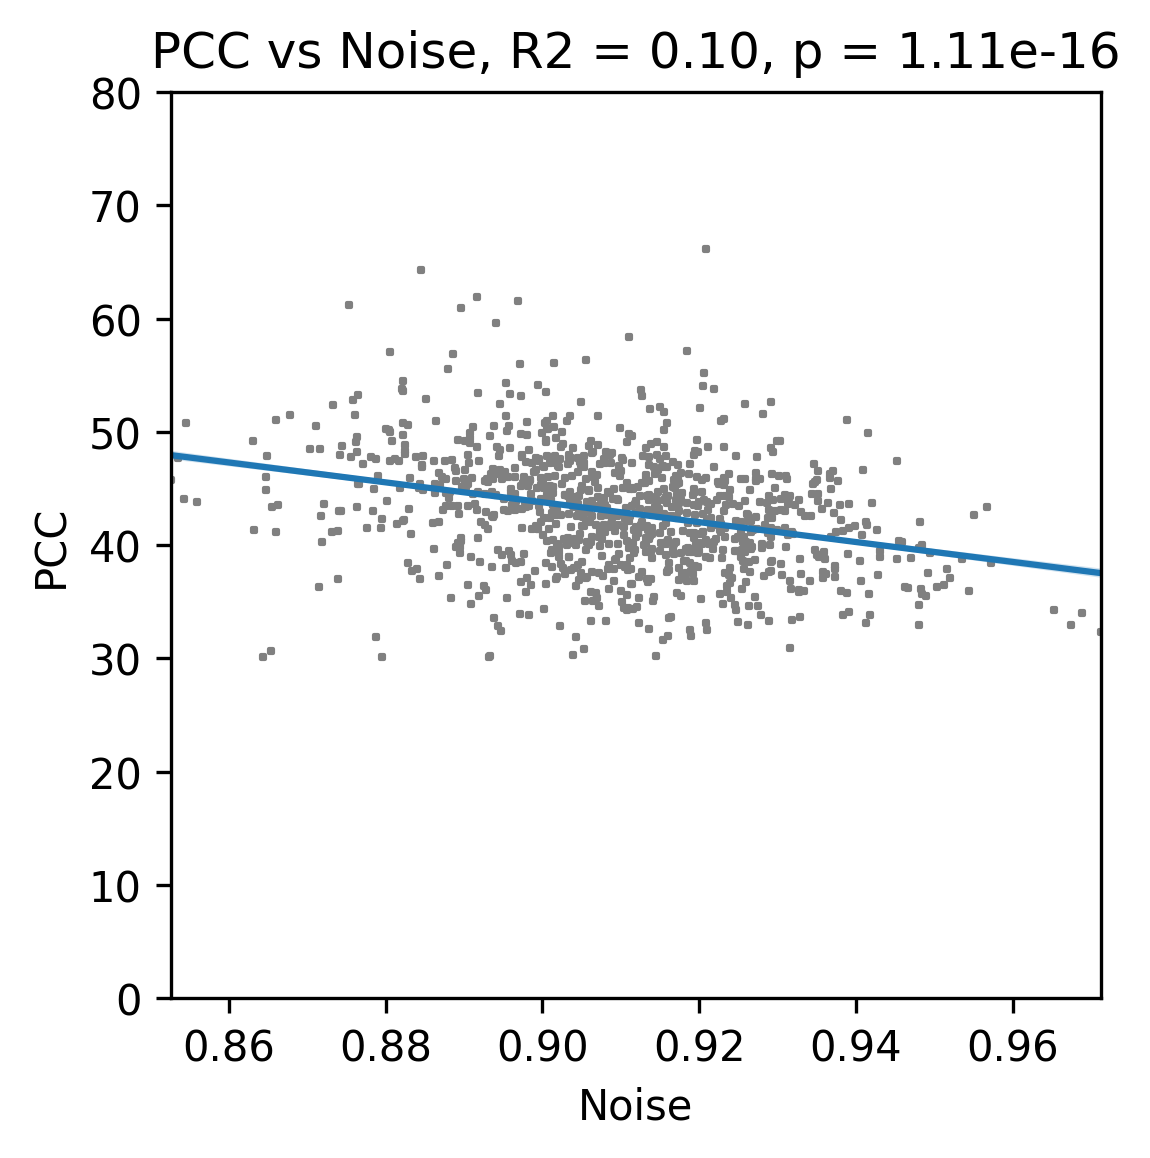

In [42]:
indGood = (pcc > 30)
from scipy.stats import f

r2adj, fval, pval, sse, sst = bivariateReg(noiseGroup[indGood], pcc[indGood], 'Noise', 'PCC', ylim = (0,80))
# Perform the ensemble correction
n = len(pcc[indGood])
k = 2 # bivariate regression
nE = 20
nEff = numUnits - nE + 1
fval = (nEff/n)*(sst-sse)/(sse/(n-k))       
dfd = nEff - k
pval = 1. - f.cdf(fval, dfn=1, dfd=dfd)

print('R2=', r2adj, 'F(1,', dfd, ')=' , fval, 'p=', pval)


In [44]:
np.sum(indGood)

1746

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


R2= 0.09934320556613618 F(1, 79 )= 8.975643155715106 p= 0.0036540354230240046


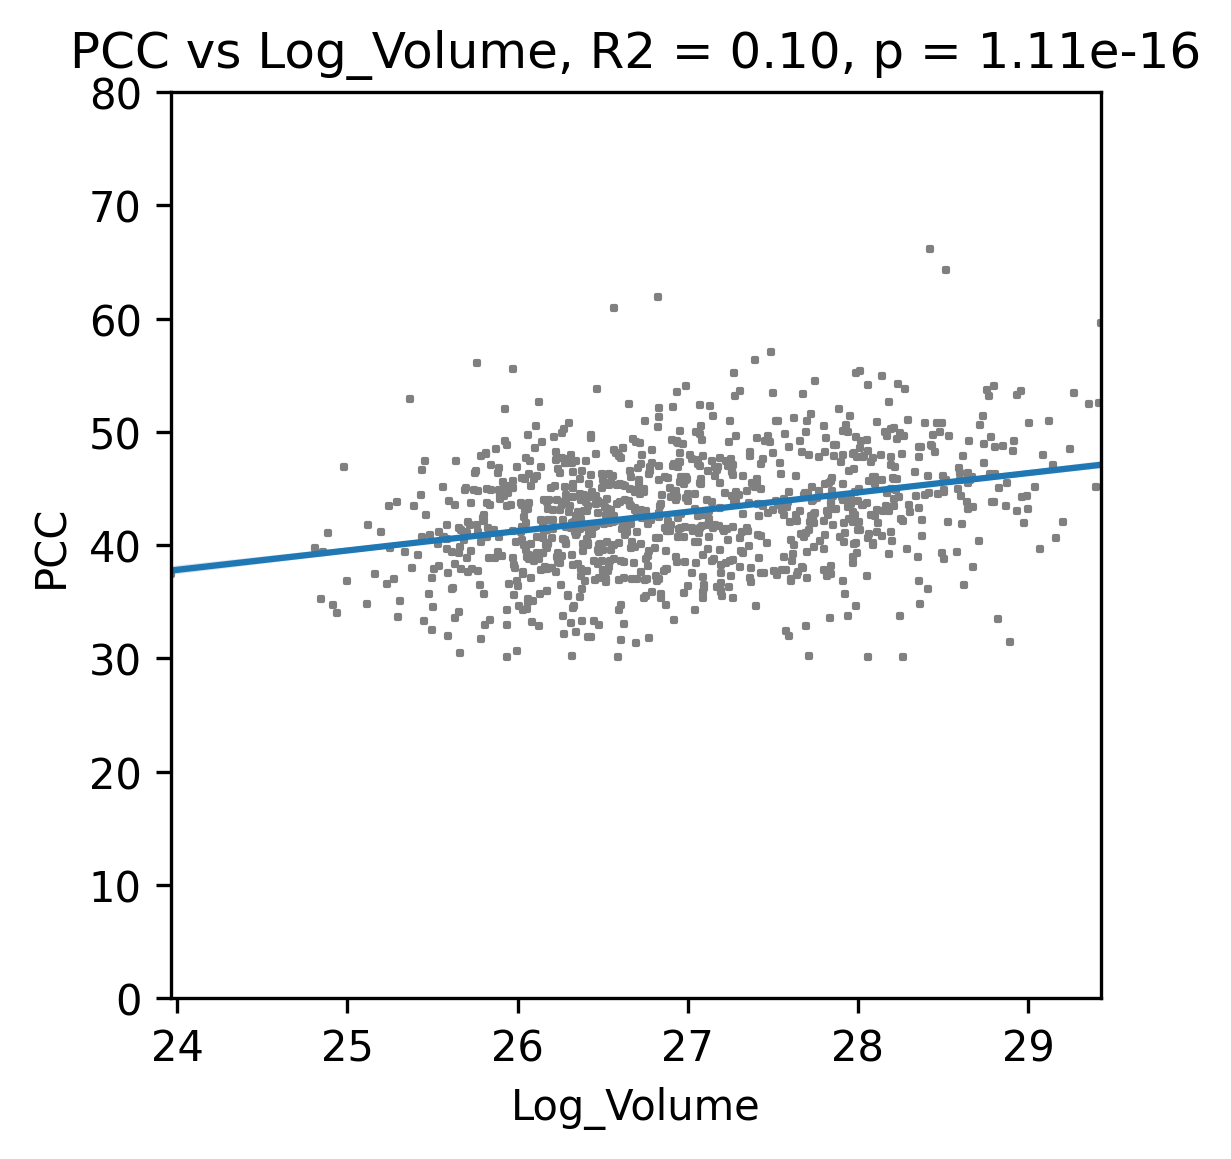

In [43]:
r2adj, fval, pval, sse, sst = bivariateReg(np.log(volumeLDA[indGood]), pcc[indGood], 'Log_Volume', 'PCC', ylim=(0,80))

n = len(pcc[indGood])
k = 2 # bivariate regression
nE = 20
nEff = numUnits - nE + 1
fval = (nEff/n)*(sst-sse)/(sse/(n-k))       
dfd = nEff - k
pval = 1. - f.cdf(fval, dfn=1, dfd=dfd)

print('R2=', r2adj, 'F(1,', dfd, ')=' , fval, 'p=', pval)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


R2= 0.07630933465989609 F(1, 79 )= 6.734254059169004 p= 0.011271074752492671


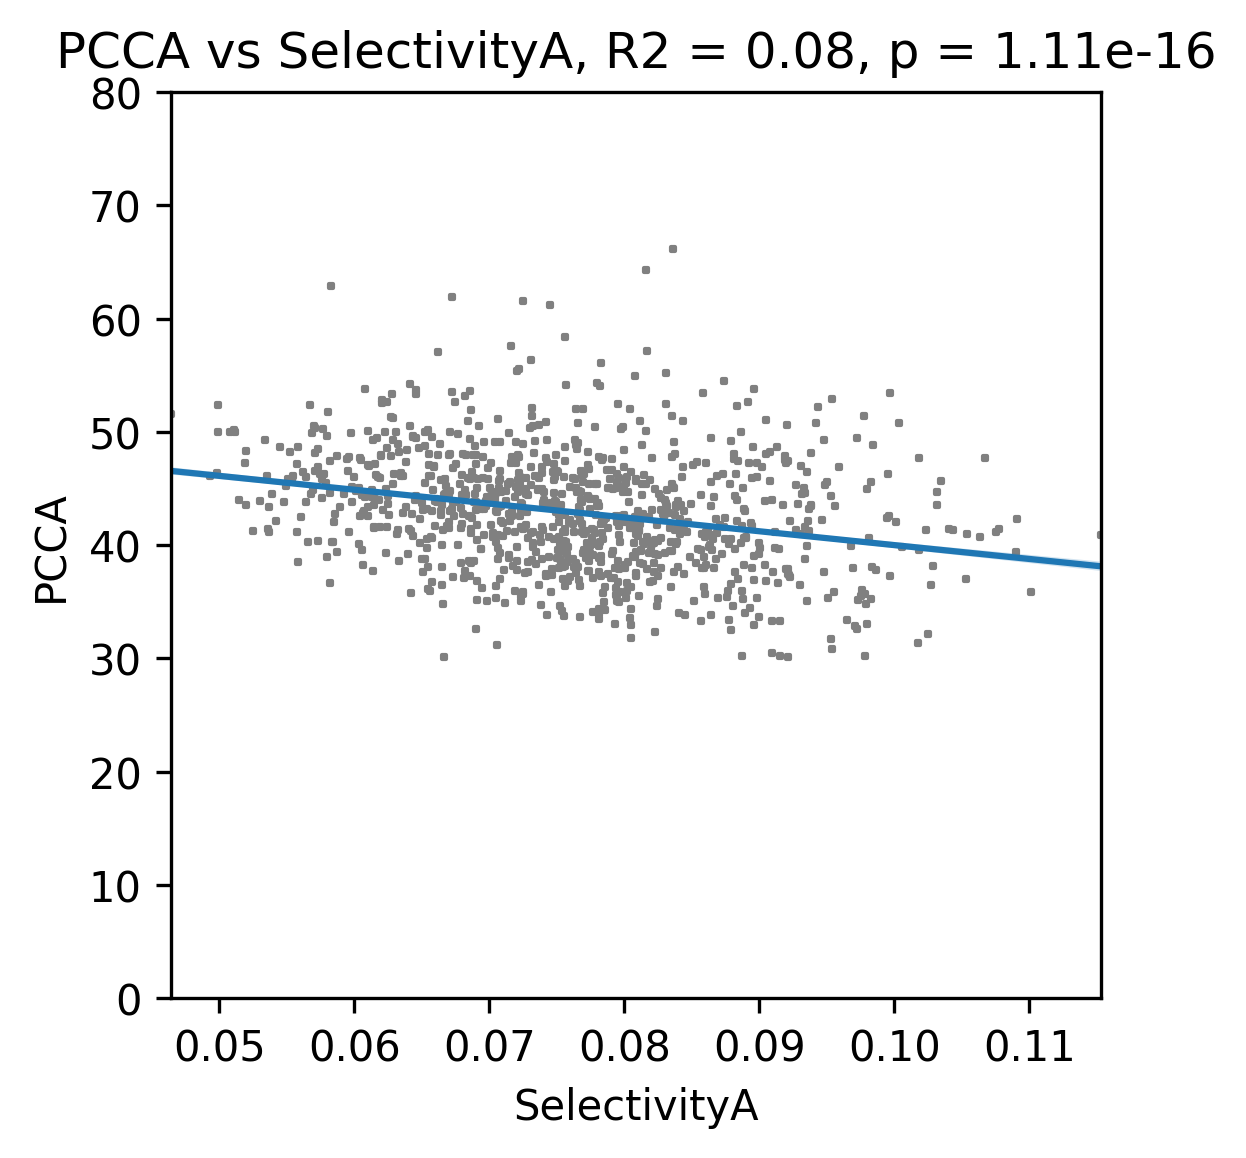

In [47]:
r2adj, fval, pval, sse, sst = bivariateReg(selHGroup[indGood], pcc[indGood], 'SelectivityA', 'PCCA', ylim=(0,80))
n = len(pcc[indGood])
k = 2 # bivariate regression
nE = 20
nEff = numUnits - nE + 1
fval = (nEff/n)*(sst-sse)/(sse/(n-k))       
dfd = nEff - k
pval = 1. - f.cdf(fval, dfn=1, dfd=dfd)

print('R2=', r2adj, 'F(1,', dfd, ')=' , fval, 'p=', pval)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


R2= -0.0005722187641308274 F(1, 79 )= 9.50707441015395e-05 p= 0.9922449924211711


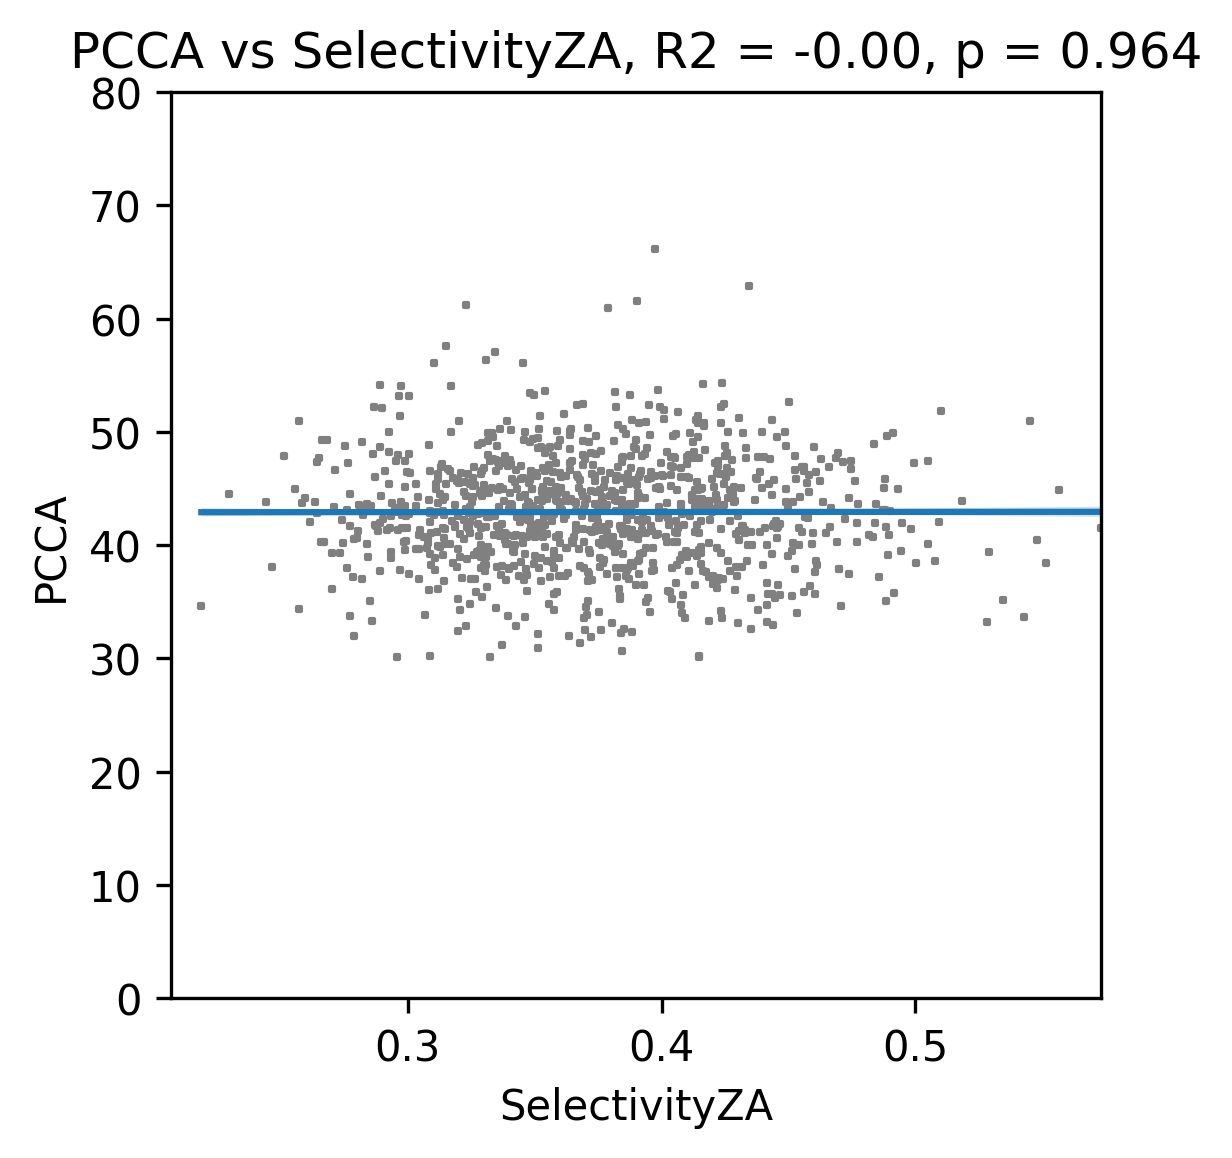

In [48]:
r2adj, fval, pval, sse, sst = bivariateReg(selzGroup[indGood], pcc[indGood], 'SelectivityZA', 'PCCA', ylim=(0,80))
n = len(pcc[indGood])
k = 2 # bivariate regression
nE = 20
nEff = numUnits - nE + 1
fval = (nEff/n)*(sst-sse)/(sse/(n-k))       
dfd = nEff - k
pval = 1. - f.cdf(fval, dfn=1, dfd=dfd)

print('R2=', r2adj, 'F(1,', dfd, ')=' , fval, 'p=', pval)

In [49]:
from sklearn.linear_model import LinearRegression
from scipy.stats import f

X = np.vstack((noiseGroup[indGood], np.log(volumeLDA[indGood]), selHGroup[indGood], selzGroup[indGood])).transpose()
y = pcc[indGood]

myModel = LinearRegression().fit( X, y)
y_pred = myModel.predict(X)

# Calculate error and statistics
n = len(y)       # Data points
k = X.shape[1]+1
sse = np.sum((y-(y_pred))**2)
sst = np.sum((y-np.mean(y))**2)

r2adj = 1. - (sse/(n-k))/(sst/(n-1))
    
nE = 20
nEff = numUnits - nE + 1
fval = (nEff/n)*((sst-sse)/(k-1))/(sse/(n-k))       
dfd = nEff - k

pval = 1. - f.cdf(fval, dfn=k-1, dfd=dfd)


print('R2=', r2adj, 'F(', k-1, ',', dfd, ')=' , fval, 'p=', pval)

R2= 0.22231780102979715 F( 4 , 76 )= 5.831990354045447 p= 0.0003792379297832271


In [50]:
print(myModel.intercept_, myModel.coef_)

87.06452402262036 [ -73.60727027    1.15104279 -119.30654754    2.27195592]


In [51]:
from sklearn.linear_model import LinearRegression
from scipy.stats import f

X = np.vstack((noiseGroup, volumeLDA, selHGroup, selzGroup)).transpose()
y = pcc

myModel = LinearRegression().fit( X, y)
y_pred = myModel.predict(X)

# Calculate error and statistics
n = len(pcc)       # Data points
k = X.shape[1]+1   # Number of parameters in the model
sse = np.sum((y-(y_pred))**2)
sst = np.sum((y-np.mean(y))**2)

r2adj = 1. - (sse/(n-k))/(sst/(n-1))
nE = 20
nEff = numUnits - nE + 1
fval = (nEff/n)*((sst-sse)/(k-1))/(sse/(n-k))       
dfd = nEff - k

pval = 1. - f.cdf(fval, dfn=k-1, dfd=dfd)


print('R2=', r2adj, 'F(', k-1, ',', dfd, ')=' , fval, 'p=', pval)

R2= 0.19099210412248768 F( 4 , 76 )= 4.8230021270574115 p= 0.001606747847479606
